# Load The Data

In [1]:
import sys
import pymongo
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bson import ObjectId
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
import re
from datetime import datetime
import string
from datetime import datetime

In [2]:
df = pd.read_csv('data/Annapolis_PD_raw_data.csv')

Parsing raw data reports, specifically to pull out 'Incidents'

In [3]:
def parse_date(date_str):
    try:
        return datetime.strptime(date_str, '%m/%d/%y').date()
    except ValueError:
        try:
            return datetime.strptime(date_str, '%m/%d/%Y').date()
        except ValueError:
            # Handle three-digit year case
            parts = date_str.split('/')
            if len(parts) == 3 and len(parts[2]) == 3:
                corrected_date_str = f"{parts[0]}/{parts[1]}/2{parts[2]}"
                try:
                    return datetime.strptime(corrected_date_str, '%m/%d/%Y').date()
                except ValueError:
                    pass
    return None

In [4]:
# Reports regular expression patterns to extract from 
dash_pattern = r'[-–—]'

incident_pattern = rf'(?P<incident_id>\d{{12}})\s*{dash_pattern}\s*(?P<incident_text>.*?)(?=\d{{12}}\s*{dash_pattern}|Hiring Entry Level|Annapolis Police Department Daily Report|$)'
hiring_pattern = r'(Hiring Entry Level.*?)(?=Submitting Anonymous Tips|Programs Offered by the Community Services Unit|$)'
tips_pattern = r'(Submitting Anonymous Tips.*?)(?=Programs Offered by the Community Services Unit|$)'
programs_pattern = r'(Programs Offered by the Community Services Unit.*?)(?=Contact Us|$)'
contact_pattern = r'(Contact Us.*?)(?=Share on Facebook|Copyright|$)'

compiled_incident = re.compile(incident_pattern, re.DOTALL | re.IGNORECASE)
compiled_hiring = re.compile(hiring_pattern, re.DOTALL | re.IGNORECASE)
compiled_tips = re.compile(tips_pattern, re.DOTALL | re.IGNORECASE)
compiled_programs = re.compile(programs_pattern, re.DOTALL | re.IGNORECASE)
compiled_contact = re.compile(contact_pattern, re.DOTALL | re.IGNORECASE)

# F1 Data

In [5]:
def create_f1_data(df):
    f1_test_records = []
    
    for _, row in df.iterrows():
        document_id = row['document_id']
        content = row['content'].lower()
        link = row['link']
        
        # Extract report date
        report_date_match = re.search(
            r'(?:daily report\s*[-–—]?\s*|^)(\d{1,2}/\d{1,2}/\d{2,4})',
            content,
            re.IGNORECASE
        )
        report_date = parse_date(report_date_match.group(1)) if report_date_match else None
        
        # Extract incidents
        for match in compiled_incident.finditer(content):
            incident_id = match.group('incident_id')
            incident_text = match.group('incident_text').strip()
            
            # Extract incident date
            incident_date_match = re.search(r'\d{1,2}/\d{1,2}/\d{2,4}', incident_text)
            incident_date = parse_date(incident_date_match.group()) if incident_date_match else None
            
            f1_test_records.append({
                'document_id': document_id,
                'incident_id': incident_id,
                'incident_date': incident_date,
                'report_date': report_date,
                'section': 'incident',
                'text': incident_text,
                'link': link
            })
        
        # Extract hiring section
        hiring_match = compiled_hiring.search(content)
        if hiring_match:
            hiring_text = hiring_match.group(1).strip()
            f1_test_records.append({
                'document_id': document_id,
                'incident_id': None,
                'incident_date': None,
                'report_date': report_date,
                'section': 'hiring',
                'text': hiring_text,
                'link': link
            })
        
        # Extract tips section
        tips_match = compiled_tips.search(content)
        if tips_match:
            tips_text = tips_match.group(1).strip()
            f1_test_records.append({
                'document_id': document_id,
                'incident_id': None,
                'incident_date': None,
                'report_date': report_date,
                'section': 'tips',
                'text': tips_text,
                'link': link
            })
        
        # Extract programs section
        programs_match = compiled_programs.search(content)
        if programs_match:
            programs_text = programs_match.group(1).strip()
            f1_test_records.append({
                'document_id': document_id,
                'incident_id': None,
                'incident_date': None,
                'report_date': report_date,
                'section': 'programs',
                'text': programs_text,
                'link': link
            })
        
        # Extract contact section
        contact_match = compiled_contact.search(content)
        if contact_match:
            contact_text = contact_match.group(1).strip()
            f1_test_records.append({
                'document_id': document_id,
                'incident_id': None,
                'incident_date': None,
                'report_date': report_date,
                'section': 'contact',
                'text': contact_text,
                'link': link
            })
    
    f1_data_test_full = pd.DataFrame(f1_test_records)
    f1_data_test_full = f1_data_test_full[['document_id', 'incident_id', 'incident_date', 'report_date', 'section', 'text', 'link']]
    f1_data_test_full['incident_id'] = f1_data_test_full['incident_id'].astype(str).replace('nan', None)
    
    return f1_data_test_full

f1_data = create_f1_data(df)
print("f1_data Sample:")
f1_data.head()

f1_data Sample:


,document_id,incident_id,incident_date,report_date,section,text,link
0,6755cb5d93a273b79e58426d,202400025855,2024-12-05,2024-12-06,incident,domestic assault - 105 francis noel way 12/5/2...,https://www.annapolis.gov/CivicSend/ViewMessag...
1,6755cb5d93a273b79e58426d,None,None,2024-12-06,hiring,hiring entry level & lateral police officersdo...,https://www.annapolis.gov/CivicSend/ViewMessag...
2,6755cb5d93a273b79e58426d,None,None,2024-12-06,tips,submitting anonymous tips to metro crime stopp...,https://www.annapolis.gov/CivicSend/ViewMessag...
3,6755cb5d93a273b79e58426d,None,None,2024-12-06,programs,programs offered by the community services uni...,https://www.annapolis.gov/CivicSend/ViewMessag...
4,6755cb5d93a273b79e58426d,None,None,2024-12-06,contact,contact us at police@annapolis.gov. victims' a...,https://www.annapolis.gov/CivicSend/ViewMessag...


In [6]:
f1_data.to_csv(r'data\F1_Annapolis_PD.csv', index = False)

Extracts sections, 
preprocesses text (stopwords, digits, punctuation), 
parses dates, 
organizes structured data into a deduplicated DataFrame called f1_data.

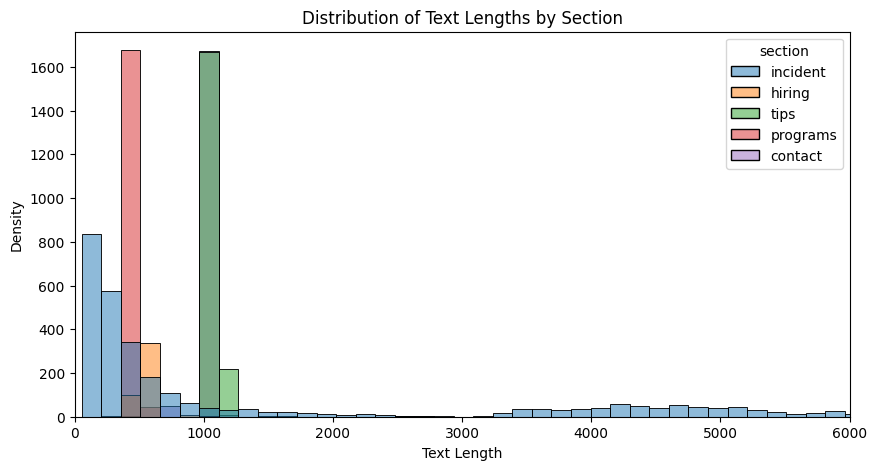

In [7]:
plt.figure(figsize=(10, 5))
sns.histplot(data=f1_data, x=f1_data['text'].str.len(), hue='section', palette='tab10', bins=80)
plt.title('Distribution of Text Lengths by Section')
plt.xlabel('Text Length')
plt.ylabel('Density')
plt.xlim(0, 6000)
plt.grid(False)
plt.show()

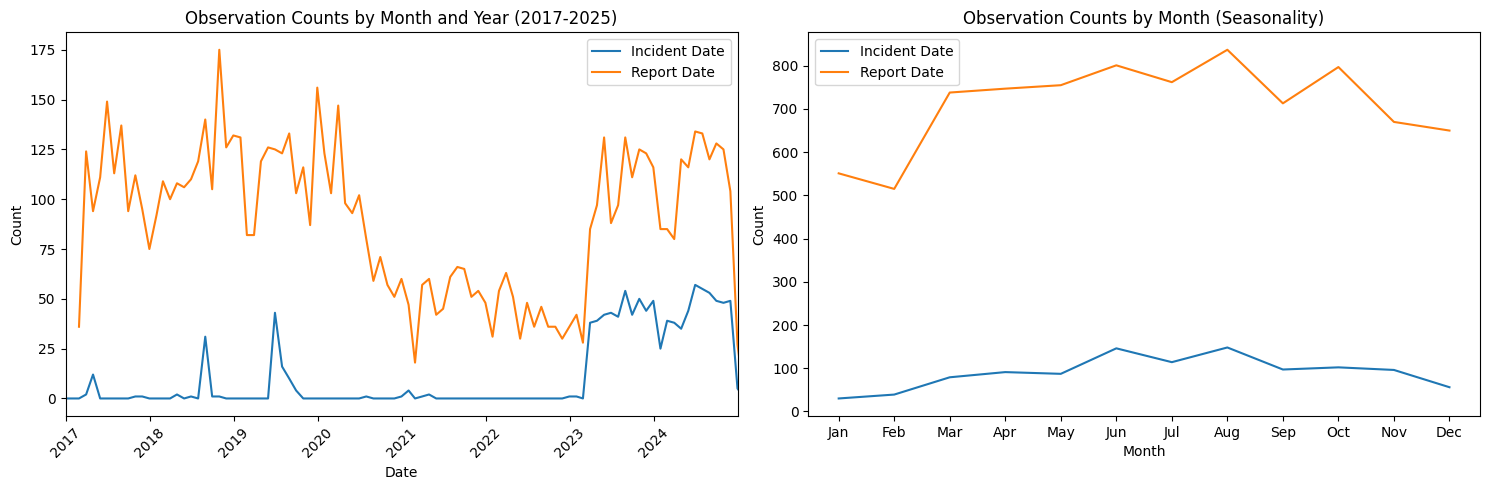

In [8]:
f1_data['incident_date'] = pd.to_datetime(f1_data['incident_date'], errors='coerce')
f1_data['report_date'] = pd.to_datetime(f1_data['report_date'], errors='coerce')

# Filter dates 
start_date = '2017-01-01'
end_date = '2024-12-31'
filtered_data = f1_data[
    ((f1_data['incident_date'] >= start_date) & (f1_data['incident_date'] <= end_date)) |
    ((f1_data['report_date'] >= start_date) & (f1_data['report_date'] <= end_date))
]

# Grouping filtered data by month and year
incident_monthly = filtered_data.groupby(pd.Grouper(key='incident_date', freq='M')).size()
report_monthly = filtered_data.groupby(pd.Grouper(key='report_date', freq='M')).size()

# Grouping by months 
f1_data['incident_month'] = f1_data['incident_date'].dt.month
f1_data['report_month'] = f1_data['report_date'].dt.month

incident_seasonal = f1_data.groupby('incident_month').size()
report_seasonal = f1_data.groupby('report_month').size()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(incident_monthly.index, incident_monthly.values, label='Incident Date')
axes[0].plot(report_monthly.index, report_monthly.values, label='Report Date')
axes[0].set_title('Observation Counts by Month and Year (2017-2025)')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Count')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(False)
axes[0].set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

axes[1].plot(incident_seasonal.index, incident_seasonal.values, label='Incident Date')
axes[1].plot(report_seasonal.index, report_seasonal.values, label='Report Date')
axes[1].set_title('Observation Counts by Month (Seasonality)')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Count')
axes[1].set_xticks(ticks=range(1, 13))
axes[1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axes[1].legend()
axes[1].grid(False)
plt.tight_layout()
plt.show()

# F2 Format

In [63]:
# Create LIBRARY table
library_df = f1_data[['document_id', 'incident_id', 'incident_date', 'report_date', 'link']].copy()
library_df['doc_length'] = f1_data['text'].str.len()  # Add document length
library_df['word_count'] = f1_data['text'].str.split().str.len()  # Add word count
library_df.head()

,document_id,incident_id,incident_date,report_date,link,doc_length,word_count
0,6755cb5d93a273b79e58426d,202400025855,2024-12-05,2024-12-06,https://www.annapolis.gov/CivicSend/ViewMessag...,348,58
1,6755cb5d93a273b79e58426d,None,NaT,2024-12-06,https://www.annapolis.gov/CivicSend/ViewMessag...,602,91
2,6755cb5d93a273b79e58426d,None,NaT,2024-12-06,https://www.annapolis.gov/CivicSend/ViewMessag...,1006,164
3,6755cb5d93a273b79e58426d,None,NaT,2024-12-06,https://www.annapolis.gov/CivicSend/ViewMessag...,464,83
4,6755cb5d93a273b79e58426d,None,NaT,2024-12-06,https://www.annapolis.gov/CivicSend/ViewMessag...,710,89


In [10]:
# Add metadata fields 
library_df['year'] = library_df['report_date'].dt.year
library_df['month'] = library_df['report_date'].dt.month
library_df['day_of_week'] = library_df['report_date'].dt.day_name()

# time delta between incident and report
library_df['report_delay'] = (library_df['report_date'] - library_df['incident_date']).dt.days
library_df.head(2)

,document_id,incident_id,incident_date,report_date,link,doc_length,word_count,year,month,day_of_week,report_delay
0,6755cb5d93a273b79e58426d,202400025855,2024-12-05,2024-12-06,https://www.annapolis.gov/CivicSend/ViewMessag...,348,58,2024.0,12.0,Friday,1.0
1,6755cb5d93a273b79e58426d,None,NaT,2024-12-06,https://www.annapolis.gov/CivicSend/ViewMessag...,602,91,2024.0,12.0,Friday,NaN


In [65]:
# Show library_df but only if incident_id is not == "test"
library_df[library_df['incident_id'] != 'None'].head()




,document_id,incident_id,incident_date,report_date,link,doc_length,word_count
0,6755cb5d93a273b79e58426d,202400025855,2024-12-05,2024-12-06,https://www.annapolis.gov/CivicSend/ViewMessag...,348,58
5,6755cb5d93a273b79e58426e,202400025813,2024-12-04,2024-12-05,https://www.annapolis.gov/CivicSend/ViewMessag...,237,41
6,6755cb5d93a273b79e58426e,202400025816,2024-12-04,2024-12-05,https://www.annapolis.gov/CivicSend/ViewMessag...,249,39
7,6755cb5d93a273b79e58426e,202400025818,2024-12-04,2024-12-05,https://www.annapolis.gov/CivicSend/ViewMessag...,260,41
12,6755cb5d93a273b79e584270,202400025682,2024-12-02,2024-12-03,https://www.annapolis.gov/CivicSend/ViewMessag...,335,53


In [11]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

def create_basic_token_table(f1_data):
    """
    Creates the F2 token table structure capturing the fundamental elements
    """
    token_records = []
    for _, row in f1_data.iterrows():
        sentences = sent_tokenize(row['text'])
        for sent_idx, sentence in enumerate(sentences):
            tokens = word_tokenize(sentence)
            for pos_idx, token in enumerate(tokens):
                token_records.append({
                    'doc_id': row['document_id'],
                    'incident_id': row['incident_id'],
                    'token_id': f"{row['document_id']}_{sent_idx}_{pos_idx}",
                    'token': token.lower(),
                    'position': pos_idx,
                    'sentence_id': sent_idx
                })
    return pd.DataFrame(token_records)

token_df = create_basic_token_table(f1_data)
token_df.head(2)

,doc_id,incident_id,token_id,token,position,sentence_id
0,6755cb5d93a273b79e58426d,202400025855,6755cb5d93a273b79e58426d_0_0,domestic,0,0
1,6755cb5d93a273b79e58426d,202400025855,6755cb5d93a273b79e58426d_0_1,assault,1,0


Clean tokens further




In [12]:
# if there are tokens that are greater than 50 len drop them from the token_df
token_df = token_df[token_df['token'].str.len() <= 50]

In [13]:
# Create a rule to drop the token if the first 3 characters are www
token_df = token_df[~token_df['token'].str.startswith('www')]

In [14]:
# Alternative approach using multiple conditions
token_df = token_df[
    (token_df['token'] != 'annapolisgov') & 
    (token_df['token'] != 'information') & 
    (token_df['token'] != 'crime') & 
    (token_df['token'] != '2hyperlinkdecrease')
]

In [15]:
def create_vocab_table(token_df):
    # Get unique terms and their frequencies
    vocab_df = token_df.groupby('token').agg({
        'doc_id': 'nunique',  # Number of documents containing term
        'token_id': 'count'   # Total frequency
    }).reset_index()
    
    vocab_df.columns = ['term', 'doc_frequency', 'total_frequency']
    vocab_df['term_id'] = range(len(vocab_df))  # Add term_id
    return vocab_df

vocab_df = create_vocab_table(token_df)
vocab_df.head(2)

,term,doc_frequency,total_frequency,term_id
0,!,148,375,0
1,#,90,164,1


In [16]:
def clean_tokens_for_analysis(token_df, vocab_df):
    """
    Cleans and filters tokens while maintaining the relationship between token_df and vocab_df.
    
    Parameters:
        token_df: DataFrame containing individual token occurrences
        vocab_df: DataFrame containing vocabulary statistics
        
    Returns:
        tuple: (cleaned_token_df, cleaned_vocab_df)
    """
    cleaned_token_df = token_df.copy()
    
    # Define domain-specific stopwords
    domain_stopwords = {
        # Location-specific terms
        'annapolis', 'maryland', 'md', 
        # Department-specific terms
        'police', 'officer', 'officers', 'dept', 'department',
    }
    
    # Combine with standard English stopwords
    from nltk.corpus import stopwords
    all_stopwords = set(stopwords.words('english')).union(domain_stopwords)
    
    def clean_token(token):
        """
        Cleans an individual token according to our rules.
        Returns None for tokens that should be removed.
        """
        # Convert to lowercase
        token = str(token).lower()
        
        # Remove all punctuation from anywhere in the token
        import string
        token = ''.join(char for char in token if char not in string.punctuation)
        
        # After punctuation removal, check if anything remains
        if not token:
            return None
            
        # Remove numbers and timestamps
        if token.isdigit():
            return None
            
        # Remove very short tokens
        if len(token) < 3:
            return None
            
        # Remove stopwords
        if token in all_stopwords:
            return None
        
        return token
    
    # Apply cleaning to tokens
    cleaned_token_df['clean_token'] = cleaned_token_df['token'].apply(clean_token)
    
    # Remove rows where cleaning resulted in None
    cleaned_token_df = cleaned_token_df.dropna(subset=['clean_token'])
    
    # Replace original token with cleaned version
    cleaned_token_df['token'] = cleaned_token_df['clean_token']
    cleaned_token_df = cleaned_token_df.drop('clean_token', axis=1)
    
    # Now rebuild vocab_df based on the cleaned tokens
    # First, get document frequencies
    doc_freq = cleaned_token_df.groupby('token')['doc_id'].nunique().reset_index()
    doc_freq.columns = ['term', 'doc_frequency']
    
    # Then, get total frequencies
    total_freq = cleaned_token_df['token'].value_counts().reset_index()
    total_freq.columns = ['term', 'total_frequency']
    
    # Combine frequencies into new vocab DataFrame
    cleaned_vocab_df = pd.merge(doc_freq, total_freq, on='term')
    
    # Add term_id to match original vocab_df structure
    cleaned_vocab_df['term_id'] = range(len(cleaned_vocab_df))
    
    # Ensure cleaned_vocab_df has the same columns as the original
    for col in vocab_df.columns:
        if col not in cleaned_vocab_df.columns and col not in ['term', 'doc_frequency', 'total_frequency', 'term_id']:
            cleaned_vocab_df[col] = None
            
    return cleaned_token_df, cleaned_vocab_df


print("Starting token and vocabulary cleaning...")
token_df_clean, vocab_df_clean = clean_tokens_for_analysis(token_df, vocab_df)

# cleaning statistics
print("\nCleaning statistics:")
print(f"Original token count: {len(token_df)}")
print(f"Cleaned token count: {len(token_df_clean)}")
print(f"Original vocabulary size: {len(vocab_df)}")
print(f"Cleaned vocabulary size: {len(vocab_df_clean)}")

# Show the impact of cleaning
print("\nMost frequent tokens before cleaning:")
print(token_df['token'].value_counts().head(10))
print("\nMost frequent tokens after cleaning:")
print(token_df_clean['token'].value_counts().head(10))

print("\nVocabulary sample before cleaning:")
print(vocab_df.head())
print("\nVocabulary sample after cleaning:")
print(vocab_df_clean.head())

Starting token and vocabulary cleaning...

Cleaning statistics:
Original token count: 1605845
Cleaned token count: 721621
Original vocabulary size: 12622
Cleaned vocabulary size: 10219

Most frequent tokens before cleaning:
token
.       76440
,       54818
the     52381
to      40601
a       37391
:       28056
or      26866
your    26052
you     25204
for     24368
Name: count, dtype: int64

Most frequent tokens after cleaning:
token
contact         17069
tip             15635
stoppers        13710
metro           11122
app              9942
vehicle          9840
annapolisgov     9814
tips             9725
program          9524
hours            7577
Name: count, dtype: int64

Vocabulary sample before cleaning:
  term  doc_frequency  total_frequency  term_id
0    !            148              375        0
1    #             90              164        1
2    $           1901             4330        2
3    %             25               26        3
4    &           1723             3035

In [17]:
token_df, vocab_df = clean_tokens_for_analysis(token_df, vocab_df)

In [18]:
vocab_df.head()

,term,doc_frequency,total_frequency,term_id
0,008y36,1,1,0
1,0107food,1,1,1
2,01082024on,1,1,2
3,01102024on,1,1,3
4,011224on,1,1,4


In [19]:
library_df.to_csv(r'data\library_df.csv', index = False)
token_df_clean.to_csv(r'data\token_df.csv', index = False)
vocab_df_clean.to_csv(r'data\vocab_df.csv', index = False)

# F3

In [20]:
import spacy

nlp = spacy.load('en_core_web_sm')

def enhance_token_table_f3(token_df):
    """
    Enhances our F2 token table with NLP annotations.
    """
    doc_texts = token_df.groupby('doc_id')['token'].apply(' '.join)
    
    nlp_features = []
    for doc_id, text in doc_texts.items():
        doc = nlp(text)
        for token in doc:
            nlp_features.append({
                'doc_id': doc_id,
                'token': token.text.lower(),
                'pos': token.pos_,        # Part of speech like NOUN, VERB
                'tag': token.tag_,        # Detailed tag like singular noun, past tense verb
                'dep': token.dep_,        # Syntactic dependency relationship
                'is_stop': token.is_stop, # Whether it's a common stop word
                'lemma': token.lemma_,    # Base form of the word
                'ent_type': token.ent_type_ if token.ent_type_ else 'O'  # Named entity type
            })
    
    enhanced_features = pd.DataFrame(nlp_features)
    
    # Merge while preserving our original F2 structure
    token_df_f3 = token_df.merge(
        enhanced_features[['doc_id', 'token', 'pos', 'tag', 'dep', 'is_stop', 'lemma', 'ent_type']], 
        on=['doc_id', 'token'],
        how='left'
    )
    return token_df_f3

token_df_f3 = enhance_token_table_f3(token_df)
token_df_f3.head(2)

,doc_id,incident_id,token_id,token,position,sentence_id,pos,tag,dep,is_stop,lemma,ent_type
0,6755cb5d93a273b79e58426d,202400025855,6755cb5d93a273b79e58426d_0_0,domestic,0,0,ADJ,JJ,amod,False,domestic,O
1,6755cb5d93a273b79e58426d,202400025855,6755cb5d93a273b79e58426d_0_0,domestic,0,0,ADJ,JJ,amod,False,domestic,O


In [21]:
def enhance_vocab_table_f3(vocab_df, token_df_f3):
    """
    Enhances our F2 vocabulary table with aggregated NLP information.
    """
    def safe_mode(x):
        if len(x) == 0:
            return None
        counts = x.value_counts()
        return counts.iloc[0] if not counts.empty else None

    # Get most common part of speech
    pos_counts = token_df_f3.groupby('token').agg({
        'pos': safe_mode
    }).reset_index()
    pos_counts.columns = ['term', 'common_pos']
    
    # Get most common entity type
    ent_counts = token_df_f3.groupby('token').agg({
        'ent_type': safe_mode
    }).reset_index()
    ent_counts.columns = ['term', 'common_ent_type']
    
    # Get canonical form (lemma)
    lemma_counts = token_df_f3.groupby('token').agg({
        'lemma': safe_mode
    }).reset_index()
    lemma_counts.columns = ['term', 'canonical_form']
    
    # Combine features
    vocab_df_f3 = vocab_df.copy()
    vocab_df_f3 = vocab_df_f3.merge(pos_counts, on='term', how='left')
    vocab_df_f3 = vocab_df_f3.merge(ent_counts, on='term', how='left')
    vocab_df_f3 = vocab_df_f3.merge(lemma_counts, on='term', how='left')
    
    return vocab_df_f3

vocab_df_f3 = enhance_vocab_table_f3(vocab_df, token_df_f3)
vocab_df_f3.head(10)

,term,doc_frequency,total_frequency,term_id,common_pos,common_ent_type,canonical_form
0,008y36,1,1,0,1.0,1.0,1.0
1,0107food,1,1,1,1.0,1.0,1.0
2,01082024on,1,1,2,1.0,1.0,1.0
3,01102024on,1,1,3,1.0,1.0,1.0
4,011224on,1,1,4,1.0,1.0,1.0
5,011324on,1,1,5,1.0,1.0,1.0
6,01138ch,1,1,6,1.0,1.0,1.0
7,01142024on,1,1,7,1.0,1.0,1.0
8,01152024on,1,2,8,4.0,4.0,4.0
9,01172024on,1,1,9,1.0,1.0,1.0


In [22]:
def enhance_library_table_f3(library_df, token_df_f3):
    """
    Enhances F2 library table with document-level linguistic summaries.
    """
    working_tokens = token_df_f3.copy()
    working_tokens = working_tokens.rename(columns={'doc_id': 'document_id'})
    
    # Calculate document-level summaries using the renamed column
    doc_summaries = working_tokens.groupby('document_id').agg({
        'pos': lambda x: x.value_counts().to_dict(),  # Distribution of parts of speech
        'ent_type': lambda x: x.value_counts().to_dict(),  # Distribution of entity types
        'is_stop': 'mean'  # Proportion of stop words
    }).reset_index()
    
    library_df_f3 = library_df.merge(doc_summaries, on='document_id', how='left')
    return library_df_f3

library_df_f3 = enhance_library_table_f3(library_df, token_df_f3)
library_df_f3.head(1)

,document_id,incident_id,incident_date,report_date,link,doc_length,word_count,year,month,day_of_week,report_delay,pos,ent_type,is_stop
0,6755cb5d93a273b79e58426d,202400025855,2024-12-05,2024-12-06,https://www.annapolis.gov/CivicSend/ViewMessag...,348,58,2024.0,12.0,Friday,1.0,"{'NOUN': 293, 'VERB': 68, 'ADJ': 54, 'PROPN': ...","{'O': 440, 'PERSON': 10, 'FAC': 8, 'TIME': 4, ...",0.048729


In [23]:
library_df_f3.to_csv(r'data\library_df_f3.csv', index = False)
token_df_f3.to_csv(r'data\token_df_f3.csv', index = False)
vocab_df_f3.to_csv(r'data\vocab_df_f3.csv', index = False)

# F4

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

def calculate_incident_tfidf(token_df):
    """
    Calculates TF-IDF scores treating each incident as a document.
    """
    # Group tokens by incident
    incident_texts = token_df.groupby('incident_id')['token'].apply(
        lambda x: ' '.join(x.str.lower())
    )
    
    # Create and configure  TF-IDF vectorizer
    vectorizer = TfidfVectorizer(
        stop_words='english',
        max_df=0.95,    # Ignore terms appearing in >95% of incidents
        min_df=2        # Ignore terms appearing in just one incident
    )
    
    # Calculate TF-IDF at the incident level
    tfidf_matrix = vectorizer.fit_transform(incident_texts)
    
    # Get terms and their IDF scores
    terms = vectorizer.get_feature_names_out()
    idfs = vectorizer.idf_
    
    # Create dictionary of scores for each term in each incident
    incident_term_scores = {}
    for incident_idx, incident_id in enumerate(incident_texts.index):
        doc_vector = tfidf_matrix[incident_idx].toarray()[0]
        for term_idx, score in enumerate(doc_vector):
            if score > 0:  # Only store non-zero scores
                term = terms[term_idx]
                incident_term_scores[(incident_id, term)] = score
    
    # Add scores back to token dataframe
    token_df_f4 = token_df.copy()
    token_df_f4['tfidf'] = token_df_f4.apply(
        lambda row: incident_term_scores.get(
            (row['incident_id'], row['token'].lower()),
            0
        ),
        axis=1
    )
    
    # statistics about token's importance
    token_stats = pd.DataFrame([
        {
            'term': term,
            'idf': idf,
            'num_incidents': (tfidf_matrix.T[idx] != 0).sum(),
            'avg_tfidf': tfidf_matrix.T[idx].mean()
        }
        for idx, (term, idf) in enumerate(zip(terms, idfs))
    ])
    
    return token_df_f4, token_stats

token_df_f4, token_stats = calculate_incident_tfidf(token_df_f3)

In [25]:
print("\nMost significant terms across all incidents:")
print(token_stats.nlargest(20, 'avg_tfidf')[['term', 'num_incidents', 'avg_tfidf']])

print("\nSample of TF-IDF scores within a single incident:")
sample_incident = token_df_f4['incident_id'].iloc[0]
print(token_df_f4[token_df_f4['incident_id'] == sample_incident]
      [['token', 'tfidf']]
      .sort_values('tfidf', ascending=False)
      .drop_duplicates('token')
      .head(20))


Most significant terms across all incidents:
              term  num_incidents  avg_tfidf
5215       vehicle           1762   0.209112
1586       contact            761   0.129450
4983           tip            680   0.092702
4745        stolen           1638   0.083652
1054         block           1521   0.075712
4753      stoppers            682   0.074045
4938         theft           1639   0.064088
2677          home           1053   0.059930
5237        victim            795   0.052635
3313         metro            682   0.049740
748   annapolisgov            701   0.044062
3952       program            667   0.040625
4851       suspect            653   0.040168
775            app            646   0.039073
4984          tips            670   0.036661
1513     community            800   0.031841
2710         hours            777   0.030189
1031       bicycle            275   0.026563
3193          make            720   0.024584
3120          live            677   0.023801

Sample o

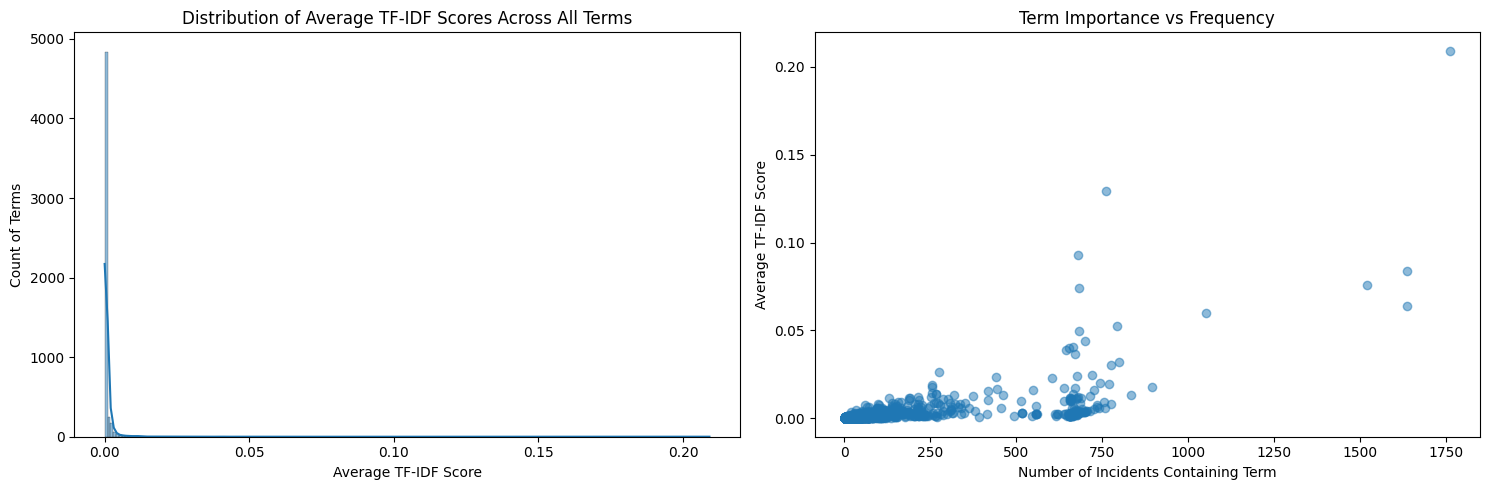


Terms grouped by importance and frequency:

Very Important, Moderately Common Terms (potential incident type indicators):
               term  num_incidents  avg_tfidf
1031        bicycle            275   0.026563
1168       burglary            441   0.023292
642         advised            256   0.018794
2027       eastport            255   0.017764
5149        unknown            444   0.016595
5142           unit            418   0.015374
4795        subject            256   0.014466
4853       suspects            266   0.013746
807   approximately            268   0.013739
1048          black            318   0.013475
2095        entered            462   0.013092
1949           door            375   0.012910
5218       vehicles            215   0.012215
4271        robbery            251   0.012097
4516          shots            187   0.011616

Incidents with unusually high average TF-IDF scores (might be unique cases):
incident_id
201900005251    0.762728
201900002231    0.727656
2

In [26]:
def analyze_tfidf_patterns(token_df_f4, token_stats):
    """
    Analyzes patterns in TF-IDF scores to understand our incident corpus.
    """
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Distribution of Average TF-IDF Scores Across All Terms
    sns.histplot(data=token_stats, x='avg_tfidf', bins=25, kde=True, ax=axes[0],binwidth=0.001,binrange=(0,0.01), )
    axes[0].set_title('Distribution of Average TF-IDF Scores Across All Terms')
    axes[0].set_xlabel('Average TF-IDF Score')
    axes[0].set_ylabel('Count of Terms')
    
    # Plot 2: Term Importance vs Frequency
    axes[1].scatter(token_stats['num_incidents'], token_stats['avg_tfidf'], alpha=0.5)
    axes[1].set_xlabel('Number of Incidents Containing Term')
    axes[1].set_ylabel('Average TF-IDF Score')
    axes[1].set_title('Term Importance vs Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Let's identify clusters of similar terms based on their TF-IDF patterns
    high_value_terms = token_stats[token_stats['avg_tfidf'] > token_stats['avg_tfidf'].mean()]
    print("\nTerms grouped by importance and frequency:")
    print("\nVery Important, Moderately Common Terms (potential incident type indicators):")
    print(high_value_terms[
        (high_value_terms['num_incidents'] > 100) & 
        (high_value_terms['num_incidents'] < 500)
    ][['term', 'num_incidents', 'avg_tfidf']].sort_values('avg_tfidf', ascending=False).head(15))

    incident_avg_tfidf = token_df_f4.groupby('incident_id')['tfidf'].mean()
    
    print("\nIncidents with unusually high average TF-IDF scores (might be unique cases):")
    print(incident_avg_tfidf.nlargest(5))

analyze_tfidf_patterns(token_df_f4, token_stats)

document sparse matrix

In [27]:
from scipy.sparse import csr_matrix

def create_document_term_matrix(token_df_f4):
    """
    Creates a document-term matrix using our TF-IDF scores.
    This will be useful for F5 analyses (PCA, LDA, etc.).
    """
    doc_term_matrix = pd.pivot_table(
        token_df_f4,
        values='tfidf',
        index='incident_id',
        columns='token',
        fill_value=0
    )
    
    sparse_matrix = csr_matrix(doc_term_matrix.values)
    
    return doc_term_matrix, sparse_matrix

# Create and save our document-term matrix for F5
doc_term_matrix, sparse_matrix = create_document_term_matrix(token_df_f4)

print("\nDocument-term matrix shape:", doc_term_matrix.shape)
print("Number of non-zero entries:", sparse_matrix.getnnz())


Document-term matrix shape: (2885, 10219)
Number of non-zero entries: 228453


In [28]:
def analyze_incident_language_patterns(token_df_f4, doc_term_matrix):
    """
    Analyzes patterns in how language is used across different police incidents.
    """
    # First, let's look at vocabulary usage per incident
    terms_per_incident = (doc_term_matrix > 0).sum(axis=1)
    
    # Find incidents with unusually rich vocabulary
    rich_vocabulary = terms_per_incident.nlargest(5)
    print("\nIncidents with largest vocabulary:")
    print(rich_vocabulary)
    
    # Look at term co-occurrences in incidents
    # This can reveal common patterns in incident descriptions
    high_value_terms = token_df_f4[token_df_f4['tfidf'] > token_df_f4['tfidf'].mean()]
    term_pairs = pd.DataFrame(columns=['term1', 'term2', 'co_occurrences'])
    
    # Get the most common pairs of important terms
    term_groups = high_value_terms.groupby('incident_id')['token'].unique()
    pair_counts = {}
    
    for terms in term_groups:
        for i, term1 in enumerate(terms):
            for term2 in terms[i+1:]:
                if term1 < term2:  # Avoid counting pairs twice
                    pair = (term1, term2)
                else:
                    pair = (term2, term1)
                pair_counts[pair] = pair_counts.get(pair, 0) + 1
    
    # Convert to DataFrame and show top pairs
    term_pairs = pd.DataFrame([
        {'term1': t1, 'term2': t2, 'co_occurrences': count}
        for (t1, t2), count in pair_counts.items()
    ]).sort_values('co_occurrences', ascending=False)
    
    print("\nMost common important term pairs (might indicate incident patterns):")
    print(term_pairs.head(15))
    
    # Look at average TF-IDF scores by position in report
    token_df_f4['normalized_position'] = token_df_f4.groupby('incident_id')['token_id'].transform(
        lambda x: (x.rank() / len(x))
    )
    
    position_importance = token_df_f4.groupby(
        pd.cut(token_df_f4['normalized_position'], bins=10)
    )['tfidf'].mean()
    
    print("\nTF-IDF importance by position in report:")
    print(position_importance)

    return terms_per_incident, term_pairs, position_importance

vocab_stats, term_pairs, position_stats = analyze_incident_language_patterns(
    token_df_f4, 
    doc_term_matrix
)


Incidents with largest vocabulary:
incident_id
None            576
201900005282    368
201900006006    368
201800005296    366
201900006071    359
dtype: int64

Most common important term pairs (might indicate incident patterns):
        term1     term2  co_occurrences
15    contact       tip             668
14    contact  stoppers             662
13   stoppers       tip             658
145     metro  stoppers             460
148   contact     metro             458
146     metro       tip             454
150       app  stoppers             341
152       app       tip             341
154       app   contact             339
156   contact   program             325
153   program       tip             325
151   program  stoppers             324
155       app   program             308
24     stolen   vehicle             298
147       app     metro             293

TF-IDF importance by position in report:
normalized_position
(-0.000995, 0.1]    0.147598
(0.1, 0.2]          0.189943
(0.2, 0.3

C:\Users\bengb\AppData\Local\Temp\ipykernel_46988\1545819336.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  position_importance = token_df_f4.groupby(


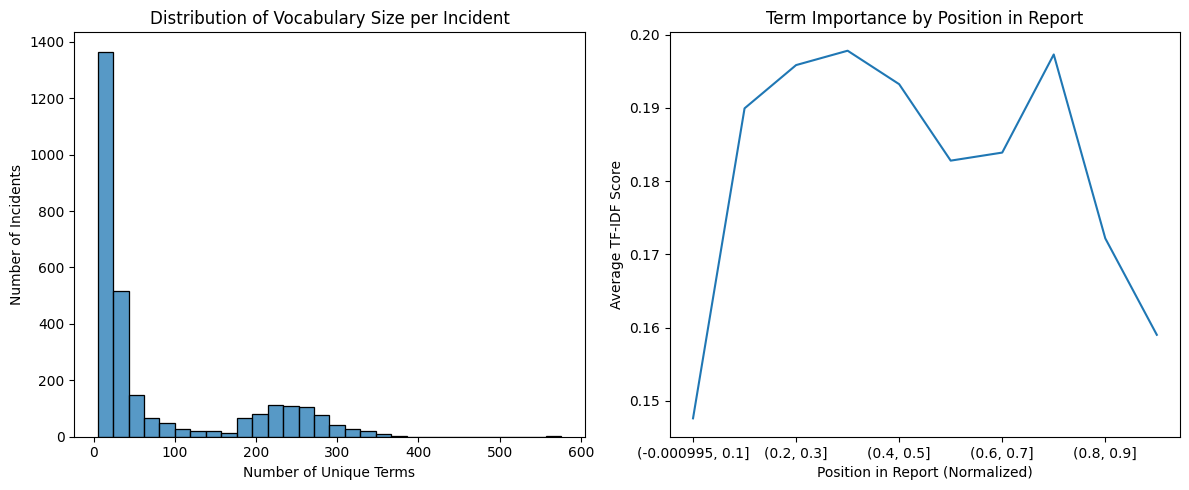

In [29]:
def visualize_incident_patterns(vocab_stats, term_pairs, position_stats):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    sns.histplot(vocab_stats, bins=30, ax=ax1)
    ax1.set_title('Distribution of Vocabulary Size per Incident')
    ax1.set_xlabel('Number of Unique Terms')
    ax1.set_ylabel('Number of Incidents')
    
    position_stats.plot(kind='line', ax=ax2)
    ax2.set_title('Term Importance by Position in Report')
    ax2.set_xlabel('Position in Report (Normalized)')
    ax2.set_ylabel('Average TF-IDF Score')
    
    plt.tight_layout()
    plt.show()

visualize_incident_patterns(vocab_stats, term_pairs, position_stats)

Variance explained by each component:
   Component  Explained_Variance  Cumulative_Variance
0          1            2.310370             2.310370
1          2            0.857334             3.167704
2          3            0.848748             4.016452
3          4            0.737215             4.753667
4          5            0.659813             5.413480
5          6            0.654419             6.067899
6          7            0.634241             6.702141
7          8            0.622613             7.324754
8          9            0.604537             7.929291
9         10            0.577219             8.506510

Most influential terms for each component:
                   Component_1                          Component_2  \
0             herefree (0.087)              colorbackground (0.141)   
1        unitannapolis (0.087)                        align (0.141)   
2          appointment (0.087)               justifyordered (0.141)   
3           submitting (0.087)          

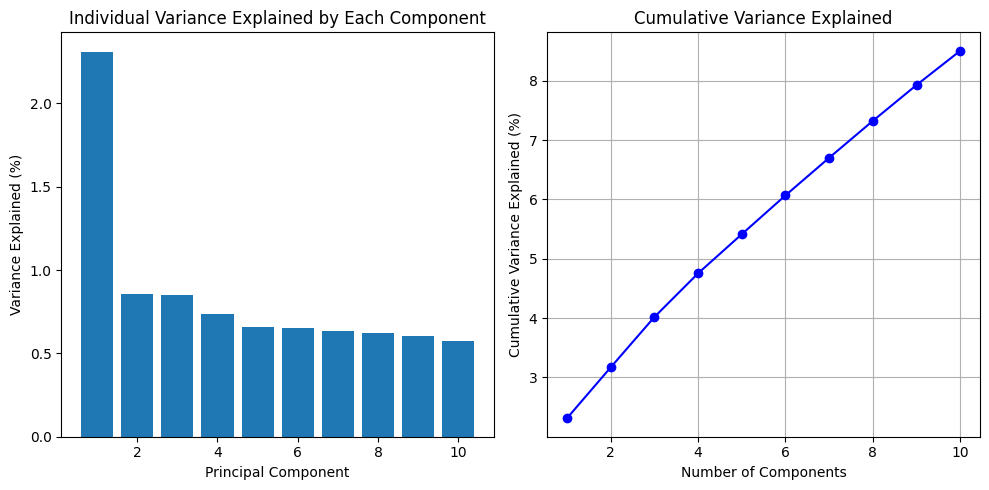

In [30]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def apply_pca_analysis(doc_term_matrix, n_components=10):
    """
    Applies PCA to our document-term matrix to find the main themes in  incidents.

    """
    # Convert DataFrame to numpy array for processing
    data_array = doc_term_matrix.values
    
    # Normalize our data - this is important because different terms occur at different frequencies
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data_array)
    
    # Apply PCA to find the main components
    pca = PCA(n_components=n_components)
    components = pca.fit_transform(scaled_data)
    
    # Create DataFrame showing how each document relates to the components
    component_df = pd.DataFrame(
        components,
        index=doc_term_matrix.index,
        columns=[f'Component_{i+1}' for i in range(n_components)]
    )
    
    # Analyze which terms are most important for each component
    feature_names = doc_term_matrix.columns
    component_terms = pd.DataFrame()
    
    for idx, component in enumerate(pca.components_):
        # Find the terms with the highest absolute weights in this component
        top_term_indices = np.abs(component).argsort()[-10:][::-1]
        
        # Store the terms and their weights
        component_terms[f'Component_{idx+1}'] = [
            f"{feature_names[i]} ({component[i]:.3f})"
            for i in top_term_indices
        ]
    
    # Calculate how much variance each component explains
    explained_variance = pd.DataFrame({
        'Component': range(1, n_components + 1),
        'Explained_Variance': pca.explained_variance_ratio_ * 100,
        'Cumulative_Variance': np.cumsum(pca.explained_variance_ratio_ * 100)
    })
    
    print("Variance explained by each component:")
    print(explained_variance)
    
    print("\nMost influential terms for each component:")
    print(component_terms)
    
    return component_df, component_terms, explained_variance

# Apply PCA to our document-term matrix
pca_results, component_terms, variance_explained = apply_pca_analysis(doc_term_matrix)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(variance_explained['Component'], variance_explained['Explained_Variance'])
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained (%)')
plt.title('Individual Variance Explained by Each Component')

plt.subplot(1, 2, 2)
plt.plot(variance_explained['Component'], 
         variance_explained['Cumulative_Variance'],
         'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained (%)')
plt.title('Cumulative Variance Explained')
plt.grid(True)
plt.tight_layout()
plt.show()

## LDA

In [31]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

def perform_topic_modeling_with_gensim(token_df, n_topics=5):
    """
    Performs topic modeling using Gensim's implementation of LDA, which works well
    with pyLDAvis for interactive visualization. 
    """
    # prepare our documents in a format Gensim can use
    documents = token_df.groupby('incident_id')['token'].apply(list).values
    
    # Create a dictionary mapping words to their IDs
    dictionary = corpora.Dictionary(documents)
    
    # Convert our documents to a bag-of-words format
    # counts how many times each word appears in each document
    corpus = [dictionary.doc2bow(doc) for doc in documents]
    
    # Create and train our LDA model
    lda_model = gensim.models.LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=n_topics,
        random_state=42,
        update_every=6,
        chunksize=20,
        passes=15,
        alpha='auto',
        per_word_topics=True
    )
    
    # Create the interactive visualization
    print("Preparing visualization...")
    lda_viz = gensimvis.prepare(lda_model, corpus, dictionary)
    
    # Get topic distributions for documentsß
    doc_topics = [lda_model.get_document_topics(doc) for doc in corpus]
    
    # Convert topic distributions to a more readable DataFrame
    doc_topic_matrix = np.zeros((len(documents), n_topics))
    for i, topics in enumerate(doc_topics):
        for topic_id, weight in topics:
            doc_topic_matrix[i, topic_id] = weight
    
    doc_topics_df = pd.DataFrame(
        doc_topic_matrix,
        columns=[f'Topic_{i+1}' for i in range(n_topics)]
    )
    
    print("\nTop words in each topic:")
    topics_words = {}
    for idx in range(n_topics):
        topic_words = lda_model.show_topic(idx, topn=15)
        topics_words[f'Topic_{idx+1}'] = [f"{word} ({prob:.3f})" for word, prob in topic_words]
        print(f"\nTopic {idx+1}:")
        for word, prob in topic_words:
            print(f"  - {word}: {prob:.3f}")
    
    return doc_topics_df, lda_model, lda_viz, dictionary, corpus

print("Starting topic modeling analysis...")
doc_topics_df, lda_model, lda_viz, dictionary, corpus = perform_topic_modeling_with_gensim(token_df_f4)

pyLDAvis.enable_notebook()
#lda_viz

def analyze_example_documents(doc_topics_df, token_df, n_examples=2):
    """
    Examines documents that are most representative of each topic, helping us
    understand what kinds of incidents each topic represents in practical terms.
    """
    for topic_idx in range(doc_topics_df.shape[1]):
        topic_col = f'Topic_{topic_idx+1}'
        print(f"\nExamples for {topic_col}:")
        
        # Find documents that are strongly associated with this topic
        top_docs = doc_topics_df.nlargest(n_examples, topic_col).index
        
        for doc_idx in top_docs:
            # Get the original text of the document
            doc_text = token_df[token_df['incident_id'] == doc_idx]['token'].str.cat(sep=' ')
            
            # Show the topic probability and a preview of the document
            print(f"\nDocument {doc_idx}")
            print(f"Topic probability: {doc_topics_df.iloc[doc_idx][topic_col]:.3f}")
            print(f"Text preview: {doc_text[:200]}...")

analyze_example_documents(doc_topics_df, token_df_f4)

Starting topic modeling analysis...
Preparing visualization...

Top words in each topic:

Topic 1:
  - community: 0.042
  - call: 0.041
  - share: 0.036
  - email: 0.024
  - make: 0.021
  - eastport: 0.017
  - contact: 0.016
  - hours: 0.016
  - city: 0.015
  - jobs: 0.014
  - home: 0.011
  - monday: 0.010
  - lateral: 0.010
  - citizen: 0.010
  - annapolisgov: 0.009

Topic 2:
  - victim: 0.060
  - suspect: 0.055
  - block: 0.042
  - street: 0.034
  - responded: 0.019
  - january: 0.016
  - approximately: 0.013
  - december: 0.013
  - area: 0.012
  - robbery: 0.011
  - male: 0.010
  - november: 0.010
  - subject: 0.010
  - theft: 0.009
  - center: 0.008

Topic 3:
  - contact: 0.109
  - tip: 0.088
  - stoppers: 0.067
  - metro: 0.044
  - app: 0.037
  - tips: 0.035
  - program: 0.035
  - annapolisgov: 0.035
  - vehicle: 0.027
  - hours: 0.021
  - live: 0.020
  - make: 0.013
  - community: 0.011
  - call: 0.011
  - home: 0.010

Topic 4:
  - vehicle: 0.310
  - theft: 0.069
  - stolen: 0.06

In [32]:
# 1. pyLDAvis (Interactive visualization)
# You already have this in your code, but make sure to display it:
pyLDAvis.enable_notebook()
pyLDAvis.display(lda_viz)

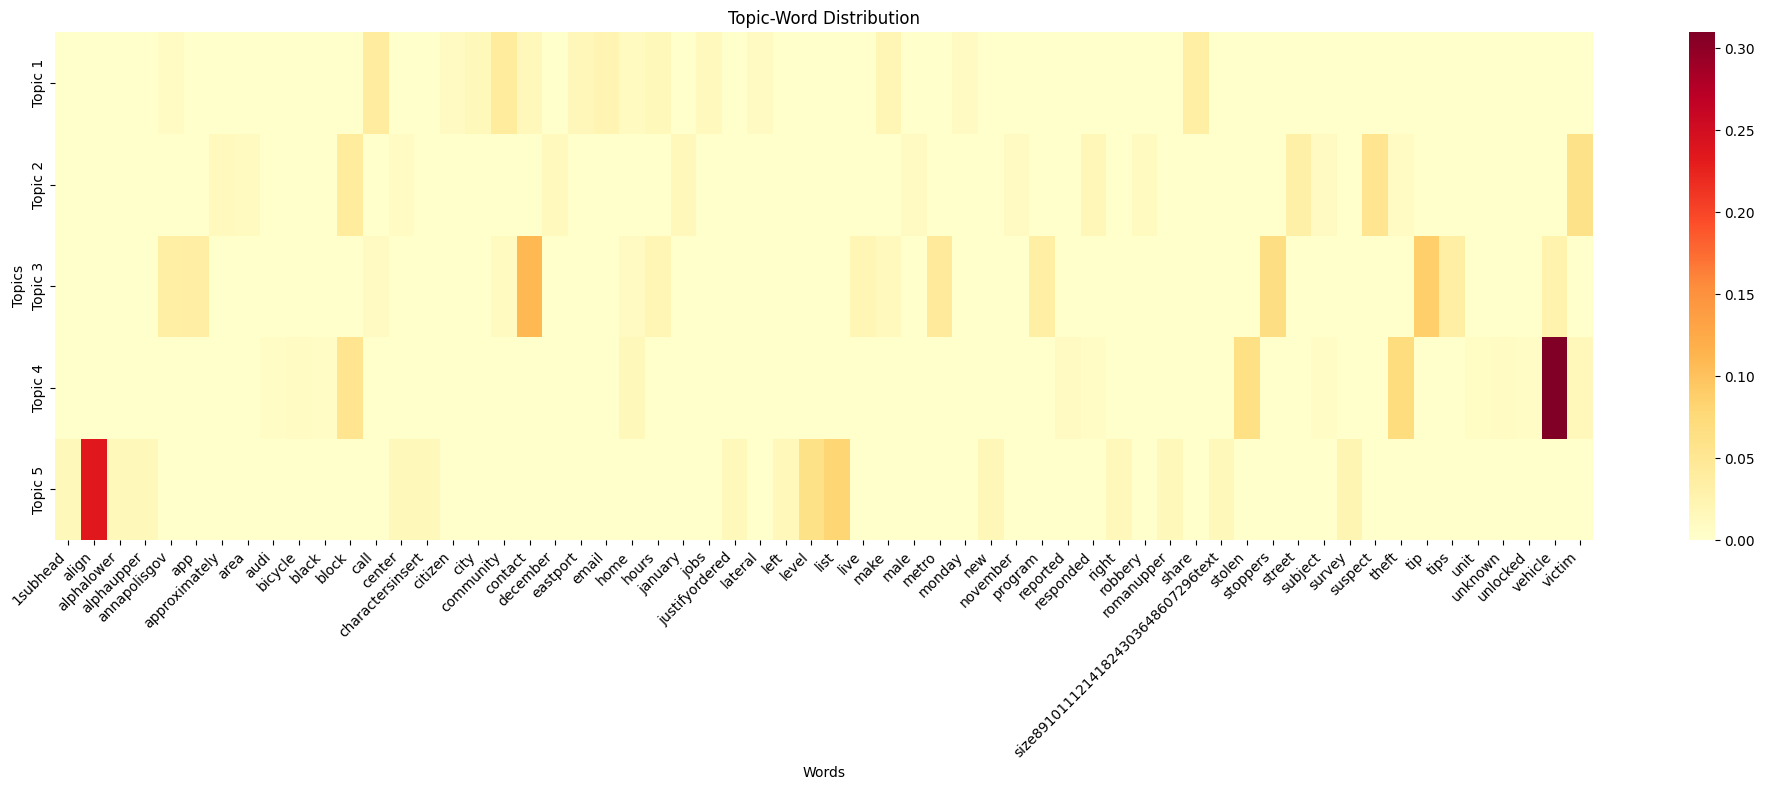

In [34]:
def plot_topic_word_heatmap(lda_model, n_words=15):
    topics_words = []
    topics_probs = []
    all_words = set()  # To collect all unique words
    
    # First pass: collect all unique words
    for topic_id in range(lda_model.num_topics):
        top_words = lda_model.show_topic(topic_id, n_words)
        words, _ = zip(*top_words)
        all_words.update(words)
    
    # Convert to sorted list for consistent ordering
    all_words = sorted(list(all_words))
    
    # Second pass: create probability matrix
    prob_matrix = np.zeros((lda_model.num_topics, len(all_words)))
    for topic_id in range(lda_model.num_topics):
        top_words = dict(lda_model.show_topic(topic_id, n_words))
        for i, word in enumerate(all_words):
            prob_matrix[topic_id, i] = top_words.get(word, 0.0)
    
    # Create heatmap
    plt.figure(figsize=(20, 8))  # Made even wider for all words
    sns.heatmap(prob_matrix, 
                xticklabels=all_words,
                yticklabels=[f'Topic {i+1}' for i in range(lda_model.num_topics)],
                cmap='YlOrRd')
    plt.title('Topic-Word Distribution')
    plt.xlabel('Words')
    plt.ylabel('Topics')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_topic_word_heatmap(lda_model)

# PCA

In [35]:
def create_pca_features(token_df_f4, vocab_df_f3, n_components=8):
    """
    Creates PCA features from our TF-IDF vectors to understand main themes in police reports.
    This analysis helps us understand the main patterns in how incidents are described.
    """
    # First, create document-term matrix from our TF-IDF values
    doc_term_matrix = pd.pivot_table(
        token_df_f4,
        values='tfidf',
        index='doc_id',
        columns='token',
        fill_value=0
    )
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    doc_components = pca.fit_transform(doc_term_matrix)
    
    # Create DataFrame of document components
    doc_components_df = pd.DataFrame(
        doc_components,
        index=doc_term_matrix.index,
        columns=[f'Component_{i+1}' for i in range(n_components)]
    )
    
    # Get term loadings (how much each term contributes to each component)
    term_loadings = pd.DataFrame(
        pca.components_.T,
        index=doc_term_matrix.columns,
        columns=[f'Component_{i+1}' for i in range(n_components)]
    )
    
    # Calculate explained variance for each component
    explained_variance = pd.DataFrame({
        'Component': range(1, n_components + 1),
        'ExplainedVariance': pca.explained_variance_ratio_ * 100,
        'CumulativeVariance': np.cumsum(pca.explained_variance_ratio_ * 100)
    })
    
    print("Variance explained by components:")
    print(explained_variance)
    
    # Show top terms for each component
    print("\nMost influential terms per component:")
    for i in range(n_components):
        component = term_loadings[f'Component_{i+1}']
        top_terms = component.nlargest(10)
        print(f"\nComponent {i+1}:")
        for term, loading in top_terms.items():
            print(f"  {term}: {loading:.3f}")
    
    return doc_components_df, term_loadings, explained_variance

doc_components_df, term_loadings, explained_variance = create_pca_features(token_df_f4, vocab_df_f3)

Variance explained by components:
   Component  ExplainedVariance  CumulativeVariance
0          1           7.365713            7.365713
1          2           4.221091           11.586803
2          3           2.941824           14.528627
3          4           2.063187           16.591815
4          5           1.533616           18.125431
5          6           1.454342           19.579773
6          7           1.211589           20.791363
7          8           1.107791           21.899153

Most influential terms per component:

Component 1:
  contact: 0.465
  vehicle: 0.362
  victim: 0.243
  stolen: 0.226
  suspect: 0.205
  program: 0.167
  annapolisgov: 0.166
  block: 0.156
  theft: 0.139
  home: 0.134

Component 2:
  victim: 0.282
  suspect: 0.232
  stolen: 0.148
  block: 0.142
  bicycle: 0.103
  theft: 0.093
  suspects: 0.089
  male: 0.087
  burglary: 0.087
  black: 0.077

Component 3:
  victim: 0.351
  suspect: 0.176
  contact: 0.176
  advised: 0.157
  block: 0.131
  approx

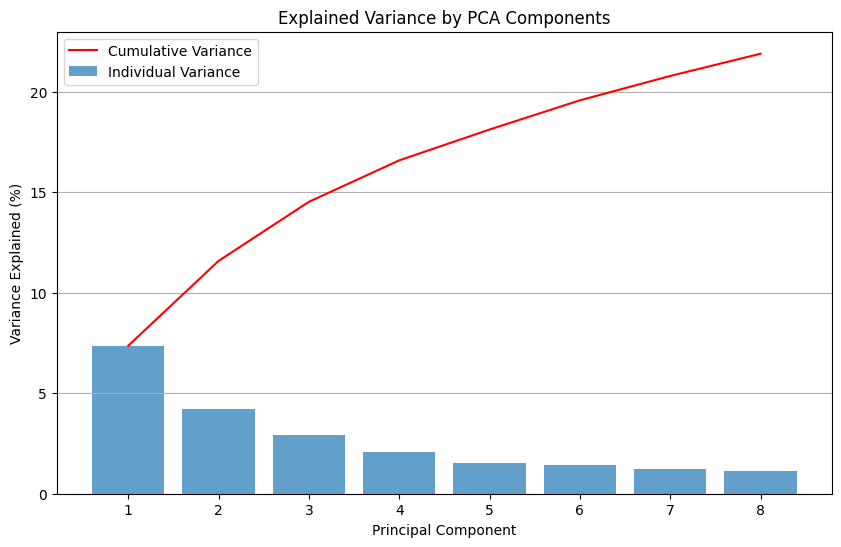

In [36]:
plt.figure(figsize=(10, 6))
plt.bar(explained_variance['Component'], explained_variance['ExplainedVariance'], alpha=0.7, label='Individual Variance')
plt.plot(explained_variance['Component'], explained_variance['CumulativeVariance'], color='red', label='Cumulative Variance')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained (%)')
plt.title('Explained Variance by PCA Components')
plt.legend()
plt.grid(axis='y')
plt.show()

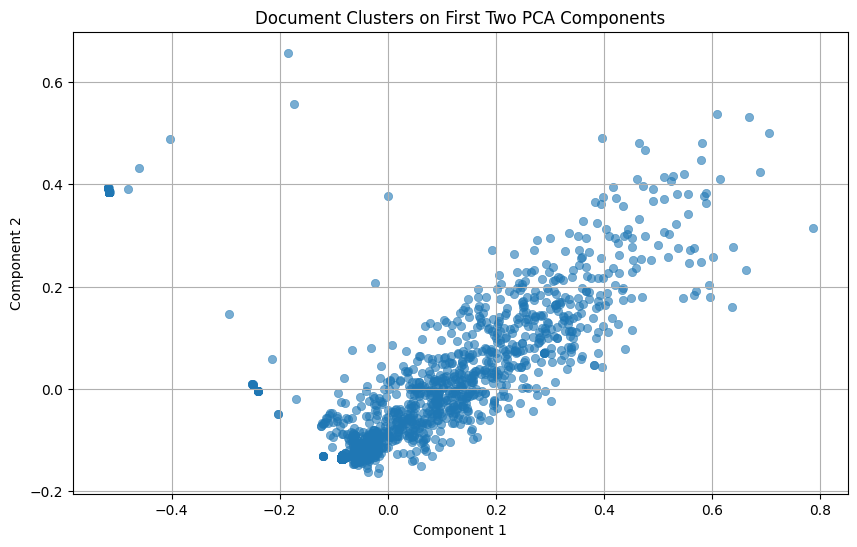

In [37]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=doc_components_df['Component_1'], y=doc_components_df['Component_2'], alpha=0.6, edgecolor=None)
plt.title('Document Clusters on First Two PCA Components')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid()
plt.show()

# Sentiment

In [38]:
from textblob import TextBlob

def analyze_sentiment(library_df):
    """
    Add sentiment polarity and subjectivity to library_df.
    """
    polarity = []
    subjectivity = []
    
    # Assuming 'text' is a column in library_df containing the document text
    for text in library_df['text']:
        blob = TextBlob(text)
        polarity.append(blob.sentiment.polarity)
        subjectivity.append(blob.sentiment.subjectivity)
    
    # Add results to the DataFrame
    library_df['sentiment_polarity'] = polarity
    library_df['sentiment_subjectivity'] = subjectivity
    return library_df

f1_data = analyze_sentiment(f1_data)

f1_data[['document_id', 'sentiment_polarity', 'sentiment_subjectivity']].head()

,document_id,sentiment_polarity,sentiment_subjectivity
0,6755cb5d93a273b79e58426d,-0.037500,0.075000
1,6755cb5d93a273b79e58426d,0.233333,0.391667
2,6755cb5d93a273b79e58426d,0.101786,0.492857
3,6755cb5d93a273b79e58426d,0.082071,0.492593
4,6755cb5d93a273b79e58426d,0.033333,0.350000


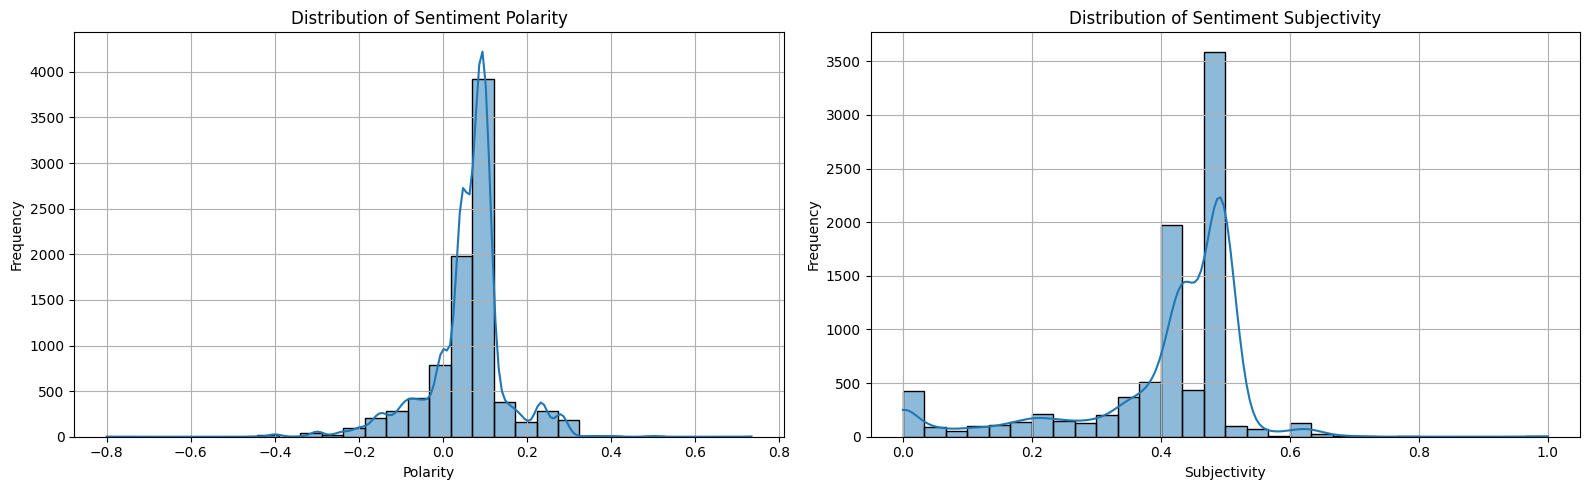

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.histplot(f1_data['sentiment_polarity'], kde=True, bins=30, ax=axes[0])
axes[0].set_title('Distribution of Sentiment Polarity')
axes[0].set_xlabel('Polarity')
axes[0].set_ylabel('Frequency')
axes[0].grid()

sns.histplot(f1_data['sentiment_subjectivity'], kde=True, bins=30, ax=axes[1])
axes[1].set_title('Distribution of Sentiment Subjectivity')
axes[1].set_xlabel('Subjectivity')
axes[1].set_ylabel('Frequency')
axes[1].grid()
plt.tight_layout()
plt.show()

C:\Users\bengb\AppData\Local\Temp\ipykernel_46988\146803949.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['month'] = filtered_data['incident_date'].dt.to_period('M')


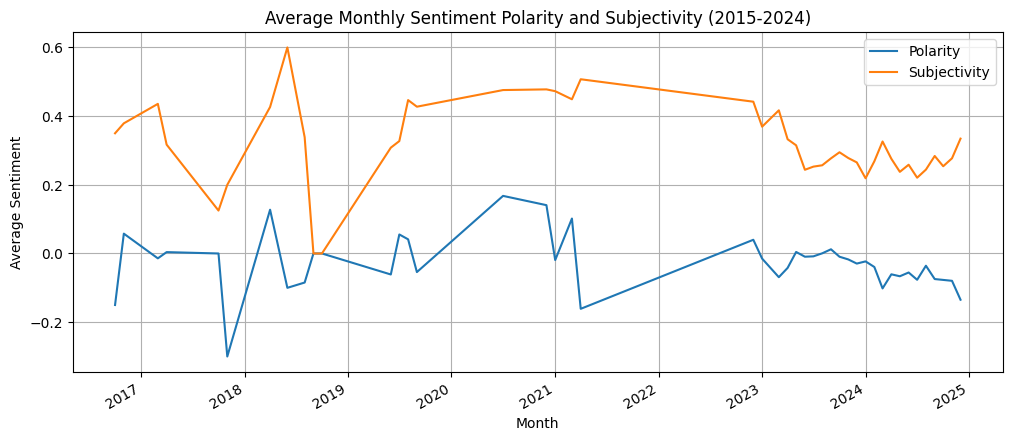

In [40]:
f1_data['incident_date'] = pd.to_datetime(f1_data['incident_date'])

start_date = '2015-01-01'
end_date = '2024-12-31'
filtered_data = f1_data[(f1_data['incident_date'] >= start_date) & (f1_data['incident_date'] <= end_date)]

# monthly average sentiment polarity and subjectivity
filtered_data['month'] = filtered_data['incident_date'].dt.to_period('M')
avg_monthly_sentiment_polarity = filtered_data.groupby('month')['sentiment_polarity'].mean()
avg_monthly_sentiment_subjectivity = filtered_data.groupby('month')['sentiment_subjectivity'].mean()

# Convert back to datetime for plotting
avg_monthly_sentiment_polarity.index = avg_monthly_sentiment_polarity.index.to_timestamp()
avg_monthly_sentiment_subjectivity.index = avg_monthly_sentiment_subjectivity.index.to_timestamp()

plt.figure(figsize=(12, 5))
avg_monthly_sentiment_polarity.plot(label='Polarity')
avg_monthly_sentiment_subjectivity.plot(label='Subjectivity')
plt.title('Average Monthly Sentiment Polarity and Subjectivity (2015-2024)')
plt.xlabel('Month')
plt.ylabel('Average Sentiment')
plt.legend()
plt.grid()
plt.show()

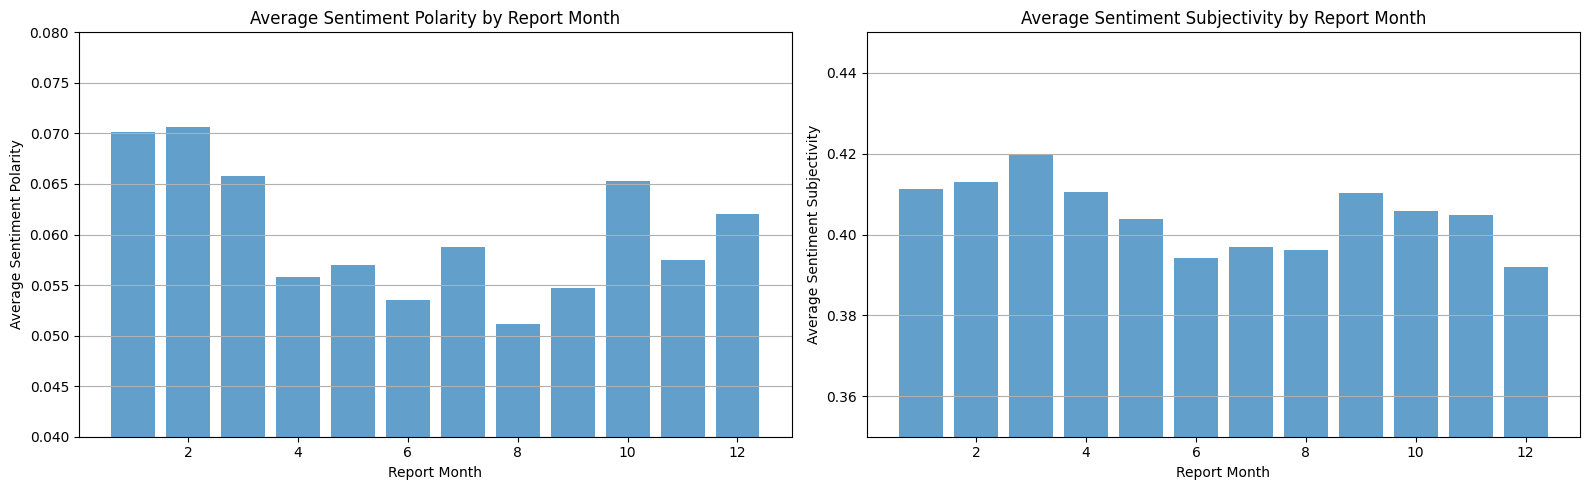

In [41]:
avg_sentiment_polarity_by_month = f1_data.groupby('report_month')['sentiment_polarity'].mean().sort_index()
avg_sentiment_subjectivity_by_month = f1_data.groupby('report_month')['sentiment_subjectivity'].mean().sort_index()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

axes[0].bar(avg_sentiment_polarity_by_month.index, avg_sentiment_polarity_by_month, alpha=0.7)
axes[0].set_title('Average Sentiment Polarity by Report Month')
axes[0].set_xlabel('Report Month')
axes[0].set_ylabel('Average Sentiment Polarity')
axes[0].set_ylim(0.04, 0.08) 
axes[0].grid(axis='y')

axes[1].bar(avg_sentiment_subjectivity_by_month.index, avg_sentiment_subjectivity_by_month, alpha=0.7)
axes[1].set_title('Average Sentiment Subjectivity by Report Month')
axes[1].set_xlabel('Report Month')
axes[1].set_ylabel('Average Sentiment Subjectivity')
axes[1].set_ylim(0.35, 0.45)  
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()

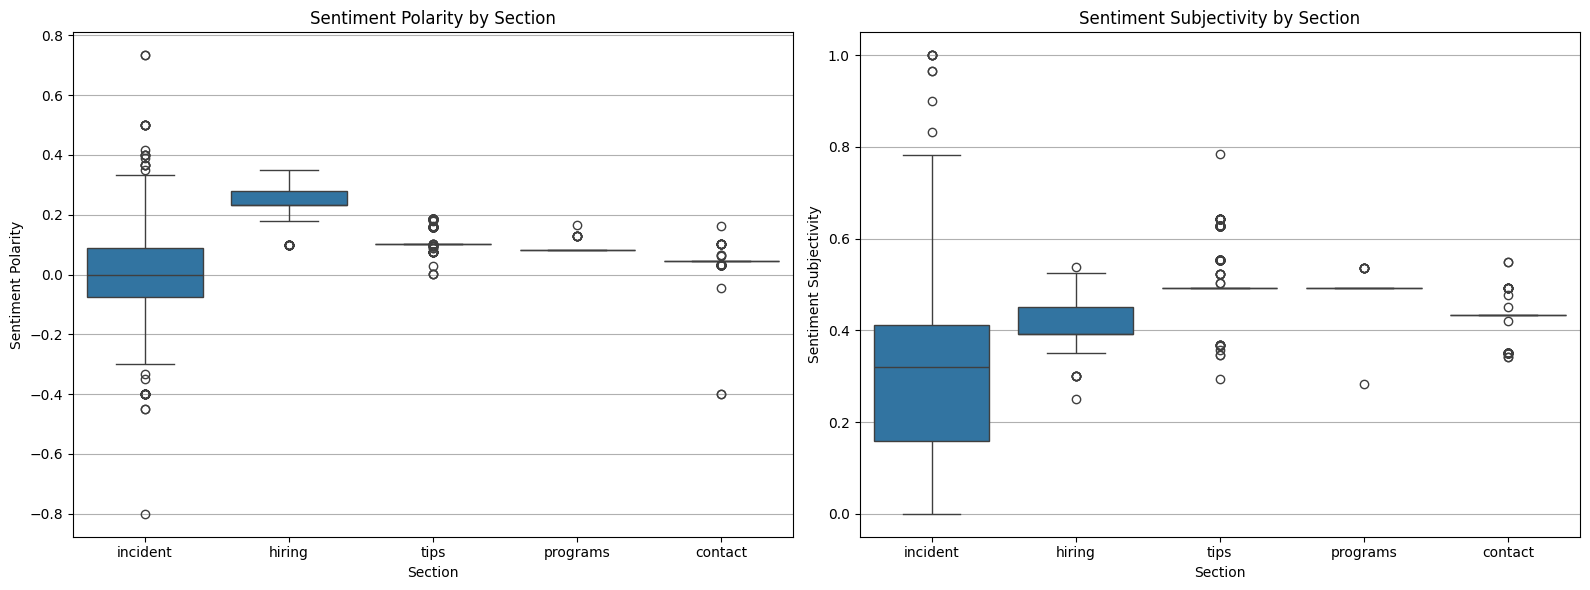

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

sns.boxplot(x='section', y='sentiment_polarity', data=f1_data, ax=axes[0])
axes[0].set_title('Sentiment Polarity by Section')
axes[0].set_xlabel('Section')
axes[0].set_ylabel('Sentiment Polarity')
axes[0].grid(axis='y')

sns.boxplot(x='section', y='sentiment_subjectivity', data=f1_data, ax=axes[1])
axes[1].set_title('Sentiment Subjectivity by Section')
axes[1].set_xlabel('Section')
axes[1].set_ylabel('Sentiment Subjectivity')
axes[1].grid(axis='y')
plt.tight_layout()
plt.show()

## Sentiment

In [43]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import download

# Download the VADER lexicon
download('vader_lexicon')

def add_sentiment_analysis(token_df, vocab_df, library_df):
    """
    Adds sentiment analysis using lemmatized tokens for more accurate sentiment scoring.
    
    Parameters:
    - token_df: DataFrame containing tokens with 'doc_id' and 'lemma' columns
    - vocab_df: vocabulary DataFrame with 'term' column
    - library_df: document metadata with 'document_id' column
    """
    # Initialize VADER
    sid = SentimentIntensityAnalyzer()
    
    # Add sentiment scores to vocabulary terms using lemmas
    print("Calculating term-level sentiment...")
    vocab_sentiments = []
    
    # Get unique lemmas from token_df to analyze
    unique_lemmas = token_df['lemma'].unique()
    
    for lemma in unique_lemmas:
        scores = sid.polarity_scores(str(lemma))
        vocab_sentiments.append({
            'lemma': lemma,
            'sentiment_score': scores['compound'],
            'negative_emotion': scores['neg'],
            'neutral_emotion': scores['neu'],
            'positive_emotion': scores['pos']
        })
    
    vocab_sentiment_df = pd.DataFrame(vocab_sentiments)
    
    # Calculate document-level sentiment using lemmas
    print("Calculating document-level sentiment...")
    doc_sentiments = []
    
    for doc_id, group in token_df.groupby('doc_id'):
        # Use lemmas instead of original tokens
        text = ' '.join(group['lemma'].astype(str))
        scores = sid.polarity_scores(text)
        
        doc_sentiments.append({
            'document_id': doc_id,
            'sentiment_compound': scores['compound'],
            'sentiment_pos': scores['pos'],
            'sentiment_neu': scores['neu'],
            'sentiment_neg': scores['neg'],
            'sentiment_category': 'positive' if scores['compound'] > 0.05 
                                else 'negative' if scores['compound'] < -0.05 
                                else 'neutral'
        })
    
    doc_sentiment_df = pd.DataFrame(doc_sentiments)
    library_df_enhanced = pd.merge(library_df, doc_sentiment_df, on='document_id', how='left')
    
    # Print detailed summary statistics
    print("\nDocument Sentiment Distribution:")
    print(doc_sentiment_df['sentiment_category'].value_counts())
    
    print("\nAverage sentiment scores across documents:")
    print(f"Compound: {doc_sentiment_df['sentiment_compound'].mean():.3f}")
    print(f"Positive: {doc_sentiment_df['sentiment_pos'].mean():.3f}")
    print(f"Negative: {doc_sentiment_df['sentiment_neg'].mean():.3f}")
    
    # Look at most positive and negative lemmas
    print("\nMost positive lemmas:")
    print(vocab_sentiment_df.nlargest(10, 'sentiment_score')[['lemma', 'sentiment_score']])
    
    print("\nMost negative lemmas:")
    print(vocab_sentiment_df.nsmallest(10, 'sentiment_score')[['lemma', 'sentiment_score']])
    
    return vocab_sentiment_df, library_df_enhanced

vocab_df_sentiment, library_df_sentiment = add_sentiment_analysis(token_df_f4, vocab_df_f3, library_df_f3)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\bengb\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Calculating term-level sentiment...
Calculating document-level sentiment...

Document Sentiment Distribution:
sentiment_category
positive    1407
negative     493
neutral        3
Name: count, dtype: int64

Average sentiment scores across documents:
Compound: 0.356
Positive: 0.069
Negative: 0.074

Most positive lemmas:
               lemma  sentiment_score
5615         freedom           0.6369
5848            love           0.6369
3699           great           0.6249
705      outstanding           0.6124
4513        gorgeous           0.6124
730          ecstasy           0.5994
2922       beautiful           0.5994
5942  congratulation           0.5994
1294          beauty           0.5859
4111         miracle           0.5859

Most negative lemmas:
         lemma  sentiment_score
505       kill          -0.6908
1388      rape          -0.6908
3622    murder          -0.6908
3212  suicidal          -0.6705
4727  fatality          -0.6705
5113   suicide          -0.6705
8571    cancer

In [44]:
token_df_f4.head()

,doc_id,incident_id,token_id,token,position,sentence_id,pos,tag,dep,is_stop,lemma,ent_type,tfidf,normalized_position
0,6755cb5d93a273b79e58426d,202400025855,6755cb5d93a273b79e58426d_0_0,domestic,0,0,ADJ,JJ,amod,False,domestic,O,0.435968,0.035714
1,6755cb5d93a273b79e58426d,202400025855,6755cb5d93a273b79e58426d_0_0,domestic,0,0,ADJ,JJ,amod,False,domestic,O,0.435968,0.035714
2,6755cb5d93a273b79e58426d,202400025855,6755cb5d93a273b79e58426d_0_1,assault,1,0,NOUN,NN,nsubj,False,assault,O,0.261246,0.083333
3,6755cb5d93a273b79e58426d,202400025855,6755cb5d93a273b79e58426d_0_1,assault,1,0,NOUN,NN,compound,False,assault,O,0.261246,0.083333
4,6755cb5d93a273b79e58426d,202400025855,6755cb5d93a273b79e58426d_0_4,francis,4,0,PROPN,NNP,compound,False,francis,PERSON,0.104204,0.261905


In [45]:
vocab_df_f3.head()

,term,doc_frequency,total_frequency,term_id,common_pos,common_ent_type,canonical_form
0,008y36,1,1,0,1.0,1.0,1.0
1,0107food,1,1,1,1.0,1.0,1.0
2,01082024on,1,1,2,1.0,1.0,1.0
3,01102024on,1,1,3,1.0,1.0,1.0
4,011224on,1,1,4,1.0,1.0,1.0


Find the text based on incident_id

In [46]:
# find f1_data where [incident_id] = 202400025110                
#f1_data[f1_data['incident_id'] == '202300027752']['text'].values[0]

# Word2Vec

In [47]:
from gensim.models import Word2Vec

def create_word_embeddings(token_df, vocab_df, vector_size=100):
    """
    Creates word embeddings with improved preprocessing for better semantic relationships.
    """
    print("Preprocessing tokens for word2vec...")
    
    def preprocess_token(token):
        """Clean individual tokens"""
        token = str(token).lower()
        # Split concatenated words (based on camelCase or other patterns)
        return token
    
    # Group tokens by document and preprocess
    sentences = []
    for _, group in token_df.groupby('doc_id'):
        sentence = [preprocess_token(token) for token in group['token']]
        sentence = [token for token in sentence if token and len(token) > 1]
        sentences.append(sentence)
    
    print(f"Training Word2Vec model on {len(sentences)} documents...")
    model = Word2Vec(
        sentences,
        vector_size=vector_size,
        window=7,          # Increased context window
        min_count=5,       # Ignore rarer words
        workers=4,
        sg=1,             # Skip-gram
        epochs=20         # More training epochs
    )
    
    print("Creating embeddings table...")
    embedding_cols = [f'embed_{i}' for i in range(vector_size)]
    embeddings = []
    
    for term in vocab_df['term']:
        try:
            vector = model.wv[str(term).lower()]
        except KeyError:
            vector = np.zeros(vector_size)
        embeddings.append(vector)
    
    embeddings_df = pd.DataFrame(
        embeddings,
        columns=embedding_cols,
        index=vocab_df.index
    )
    
    vocab_df_enhanced = pd.concat([vocab_df, embeddings_df], axis=1)
    
    # semantic relationships
    test_words = ['vehicle', 'victim', 'theft', 'assault', 'suspect', 'officer']
    print("\nKey term relationships:")
    for word in test_words:
        try:
            similar = model.wv.most_similar(word, topn=5)
            print(f"\nTerms related to '{word}':")
            for similar_word, score in similar:
                print(f"  - {similar_word}: {score:.3f}")
        except KeyError:
            print(f"'{word}' not found in vocabulary")
    
    # Analyze specific crime categories
    crime_types = ['theft', 'robbery', 'assault', 'burglary']
    print("\nCrime type analysis:")
    for crime in crime_types:
        try:
            # Get related terms
            related = model.wv.most_similar(positive=[crime], topn=5)
            print(f"\nTerms associated with {crime}:")
            for term, score in related:
                print(f"  - {term}: {score:.3f}")
            
            # Try to find victim/suspect patterns
            context = model.wv.most_similar(
                positive=[crime, 'victim'],
                negative=['report'],
                topn=3
            )
            print(f"Common context ({crime} + victim):")
            for term, score in context:
                print(f"  - {term}: {score:.3f}")
        except KeyError:
            continue
    
    return vocab_df_enhanced, model

vocab_df_with_embeddings, word2vec_model = create_word_embeddings(token_df_f4, vocab_df_f3)

Preprocessing tokens for word2vec...
Training Word2Vec model on 1903 documents...
Creating embeddings table...

Key term relationships:

Terms related to 'vehicle':
  - window: 0.587
  - disabled: 0.560
  - driven: 0.554
  - lexus: 0.545
  - nationwide: 0.541

Terms related to 'victim':
  - stab: 0.700
  - stabbed: 0.674
  - abdomen: 0.654
  - finger: 0.651
  - apparent: 0.649

Terms related to 'theft':
  - auto: 0.604
  - 510pm: 0.557
  - burglary: 0.548
  - hunting: 0.527
  - garden: 0.524

Terms related to 'assault':
  - aggravated: 0.750
  - cruelty: 0.699
  - deg: 0.651
  - endangerment: 0.638
  - reckless: 0.612

Terms related to 'suspect':
  - brief: 0.581
  - fell: 0.547
  - identified: 0.532
  - brandishing: 0.527
  - broadway: 0.526
'officer' not found in vocabulary

Crime type analysis:

Terms associated with theft:
  - auto: 0.604
  - 510pm: 0.557
  - burglary: 0.548
  - hunting: 0.527
  - garden: 0.524
Common context (theft + victim):
  - stab: 0.465
  - knives: 0.456
  - 

## Stolen Cars

In [48]:
def analyze_vehicles(model):
    """Analyze vehicle-related terms in the embeddings"""
    # Base vehicle terms
    vehicle_terms = ['car', 'vehicle', 'truck', 'suv']
    make_terms = ['honda', 'toyota', 'ford', 'chevrolet', 'bmw', 'mercedes']
    
    print("\nVehicle Analysis:")
    
    # Analyze base vehicle terms
    for term in vehicle_terms:
        try:
            similar = model.wv.most_similar(term, topn=7)
            print(f"\nTerms related to '{term}':")
            for similar_word, score in similar:
                print(f"  - {similar_word}: {score:.3f}")
        except KeyError:
            continue
    
    # Look for make/model patterns
    print("\nCar Make Analysis:")
    for make in make_terms:
        try:
            # Find models and contexts
            similar = model.wv.most_similar(
                positive=[make, 'vehicle'],
                topn=5
            )
            print(f"\nContext for {make}:")
            for term, score in similar:
                print(f"  - {term}: {score:.3f}")
        except KeyError:
            continue
    
    # Analyze theft context
    try:
        theft_context = model.wv.most_similar(
            positive=['vehicle', 'theft'],
            topn=5
        )
        print("\nVehicle theft context:")
        for term, score in theft_context:
            print(f"  - {term}: {score:.3f}")
    except KeyError:
        pass

# Use with your model:
analyze_vehicles(word2vec_model)


Vehicle Analysis:

Terms related to 'car':
  - helps: 0.725
  - appointment: 0.658
  - prevent: 0.628
  - watch: 0.625
  - small: 0.559
  - program: 0.525
  - today: 0.500

Terms related to 'vehicle':
  - window: 0.587
  - disabled: 0.560
  - driven: 0.554
  - lexus: 0.545
  - nationwide: 0.541
  - rear: 0.530
  - sticker: 0.529

Terms related to 'truck':
  - bed: 0.769
  - tow: 0.677
  - texas: 0.637
  - roof: 0.633
  - pickup: 0.632
  - pick: 0.617
  - corolla: 0.614

Terms related to 'suv':
  - sienna: 0.723
  - minivan: 0.723
  - acura: 0.705
  - silver: 0.704
  - bearing: 0.700
  - altima: 0.699
  - crv: 0.695

Car Make Analysis:

Context for honda:
  - lexus: 0.724
  - pilot: 0.705
  - accord: 0.694
  - kia: 0.688
  - halsey: 0.687

Context for toyota:
  - prius: 0.743
  - camry: 0.732
  - 4runner: 0.730
  - sienna: 0.720
  - lexus: 0.715

Context for ford:
  - f150: 0.744
  - 4runner: 0.708
  - lexus: 0.699
  - ranger: 0.697
  - chevrolet: 0.692

Context for chevrolet:
  - 4run

# Misc Plots

Preparing vectors for t-SNE...


c:\Users\bengb\AppData\Local\Programs\Python\Python310\lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


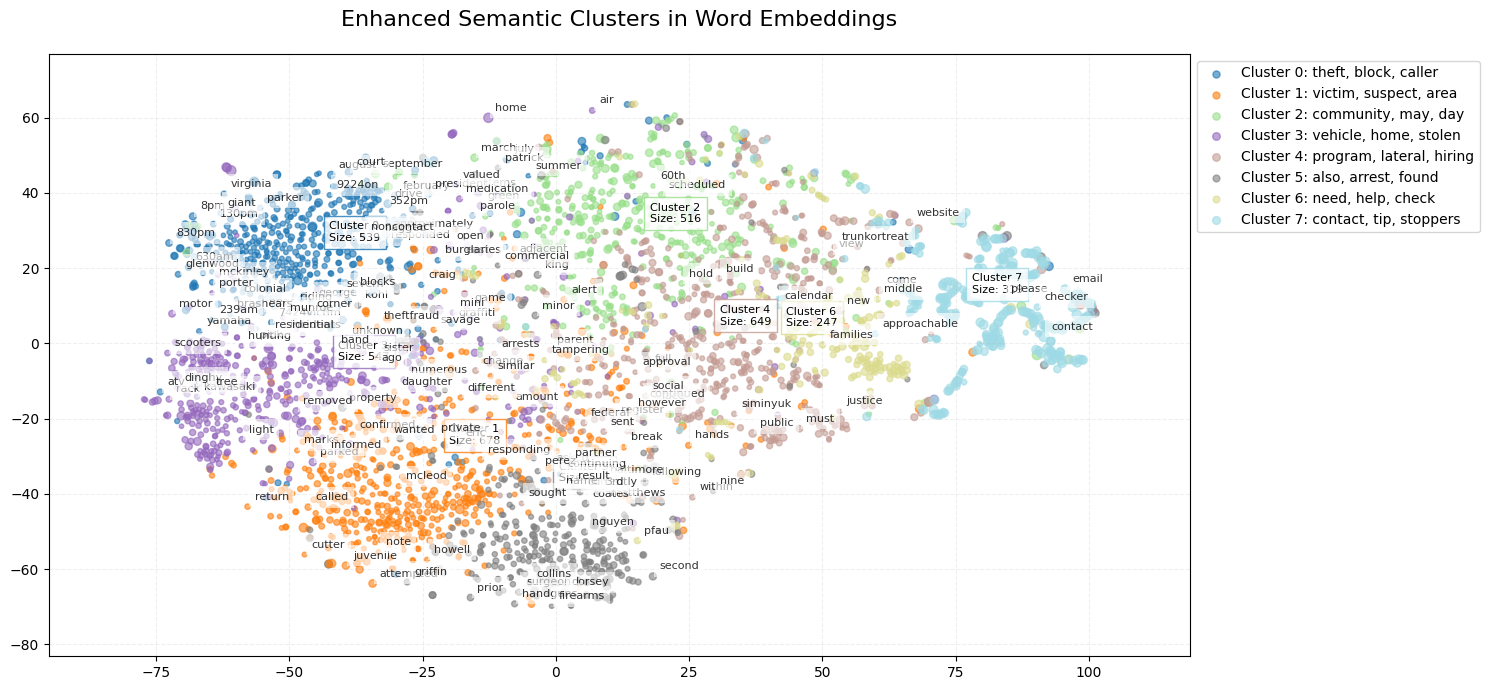

In [49]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial import cKDTree

def create_zoomed_semantic_tsne(word2vec_model, min_freq=5, n_clusters=8, perplexity=40, max_labels=300):
    """
    Creates a zoomed-in t-SNE visualization with semantic clustering.
    """
    print("Preparing vectors for t-SNE...")
    words = []
    vectors = []
    frequencies = []
    
    for word in word2vec_model.wv.index_to_key:
        freq = word2vec_model.wv.get_vecattr(word, "count")
        vectors.append(word2vec_model.wv[word])
        words.append(word)
        frequencies.append(freq)
    
    vectors = np.array(vectors)
    frequencies = np.array(frequencies)
    
    # Normalize vectors
    scaler = StandardScaler()
    vectors_normalized = scaler.fit_transform(vectors)
    
    # Enhanced t-SNE
    tsne = TSNE(
        n_components=2,
        perplexity=min(perplexity, len(vectors) - 1),
        n_iter=5000,
        random_state=42,
        init='pca',
        early_exaggeration=20.0,
        learning_rate='auto',
        metric='cosine',
        n_jobs=-1
    )
    
    vectors_tsne = tsne.fit_transform(vectors_normalized)
    
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(vectors_normalized)
    
    plt.figure(figsize=(15, 7))
    
    colors = plt.cm.tab20(np.linspace(0, 1, n_clusters))
    
    for i in range(n_clusters):
        mask = cluster_labels == i
        
        cluster_words = [words[j] for j in range(len(words)) if cluster_labels[j] == i]
        cluster_freqs = [frequencies[j] for j in range(len(frequencies)) if cluster_labels[j] == i]
        top_words = [w for _, w in sorted(zip(cluster_freqs, cluster_words), reverse=True)[:5]]
        
        # Calculate cluster metrics
        avg_freq = np.mean(cluster_freqs)
        cluster_size = np.sum(mask)
        
        sizes = 50 * (np.log1p(frequencies[mask]) / np.max(np.log1p(frequencies))) + 3
        plt.scatter(
            vectors_tsne[mask, 0],
            vectors_tsne[mask, 1],
            c=[colors[i]],
            alpha=0.6,
            s=sizes,
            label=f'Cluster {i}: {", ".join(top_words[:3])}'
        )
        
        center = np.mean(vectors_tsne[mask], axis=0)
        stats_text = f'Cluster {i}\nSize: {cluster_size}'
        plt.annotate(
            stats_text,
            xy=(center[0], center[1]),
            xytext=(5, 5),
            textcoords='offset points',
            bbox=dict(facecolor='white', edgecolor=colors[i], alpha=0.8),
            fontsize=8,
            ha='left',
            va='bottom'
        )
    
    # Add labels for selected points
    tree = cKDTree(vectors_tsne)
    labeled_points = set()
    min_distance = 2.0
    
    sorted_indices = np.argsort(frequencies)[::-1]
    for idx in sorted_indices:
        if len(labeled_points) >= max_labels:
            break
            
        if labeled_points:
            distances, _ = tree.query(vectors_tsne[idx], k=2)
            if distances[1] < min_distance:
                continue
                
        labeled_points.add(idx)
        plt.annotate(
            words[idx],
            (vectors_tsne[idx, 0], vectors_tsne[idx, 1]),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=8,
            alpha=0.8,
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.6)
        )
    
    # Calculate padding as a percentage of data range
    padding = 0.1  # 10% padding
    x_range = vectors_tsne[:, 0].max() - vectors_tsne[:, 0].min()
    y_range = vectors_tsne[:, 1].max() - vectors_tsne[:, 1].min()
    
    plt.xlim(
        vectors_tsne[:, 0].min() - x_range * padding,
        vectors_tsne[:, 0].max() + x_range * padding
    )
    plt.ylim(
        vectors_tsne[:, 1].min() - y_range * padding,
        vectors_tsne[:, 1].max() + y_range * padding
    )
    
    plt.title('Enhanced Semantic Clusters in Word Embeddings', pad=20, fontsize=16)
    plt.grid(True, alpha=0.2, linestyle='--')
    plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', fontsize=10)
    plt.tight_layout()
    plt.show()
    return vectors_tsne, words, cluster_labels

vectors_tsne, words, clusters = create_zoomed_semantic_tsne(word2vec_model)

# Hiearchical Model

In [50]:
words = list(word2vec_model.wv.index_to_key)
vectors = [word2vec_model.wv[word] for word in words]
features_for_clustering = np.array(vectors)

In [51]:
from scipy.cluster.hierarchy import fcluster
#n_clusters = 6

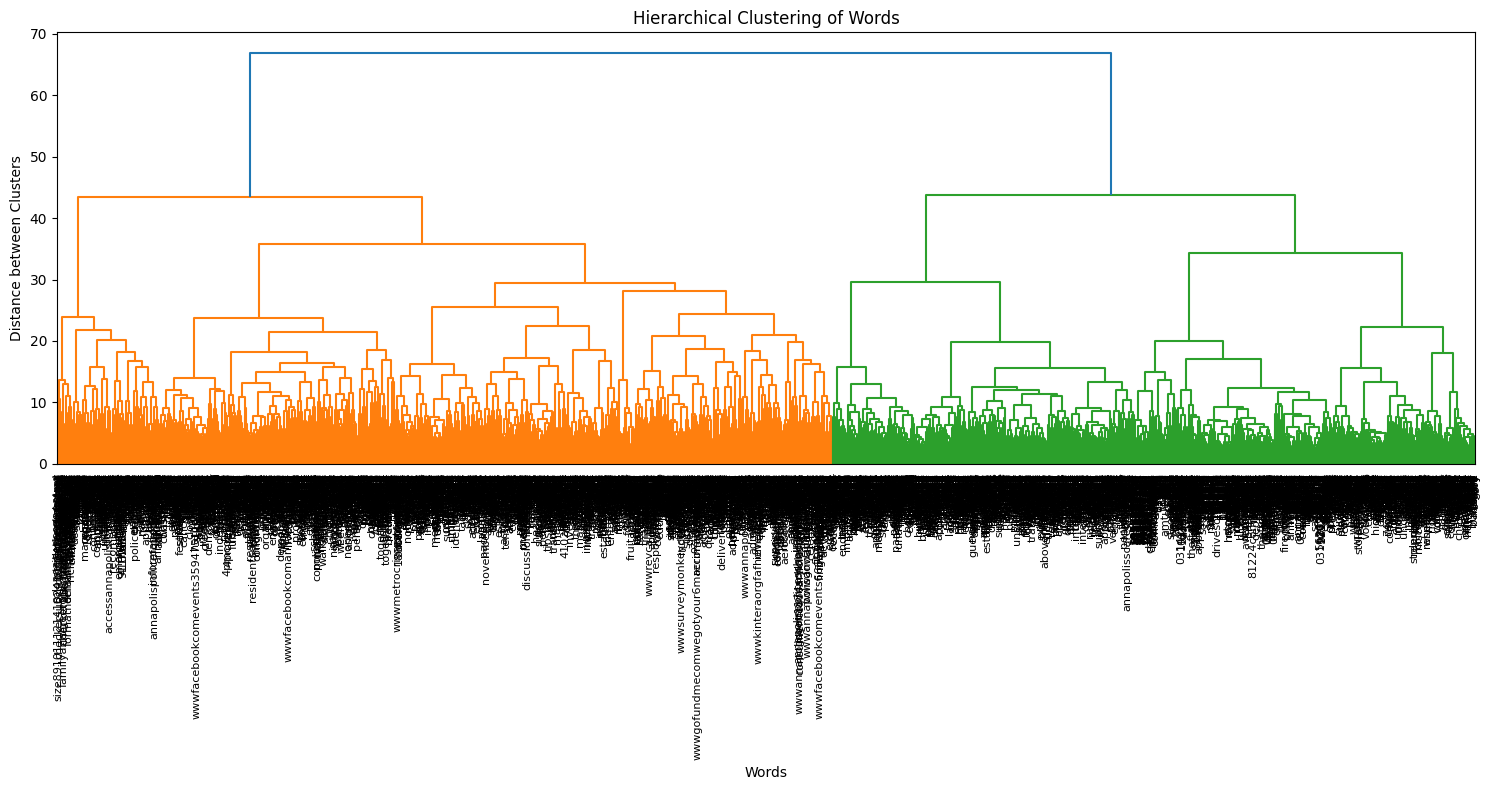

In [52]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Perform hierarchical clustering
linkage_matrix = linkage(features_for_clustering, method='ward')

# Create the dendrogram
plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix, 
           labels=words,
           #leaf_rotation=90,
           leaf_font_size=8,
           color_threshold=0.9 * max(linkage_matrix[:,2]))

plt.title('Hierarchical Clustering of Words')
plt.xlabel('Words')
plt.ylabel('Distance between Clusters')
plt.tight_layout()
plt.show()

In [53]:
token_df_f3.head()

,doc_id,incident_id,token_id,token,position,sentence_id,pos,tag,dep,is_stop,lemma,ent_type
0,6755cb5d93a273b79e58426d,202400025855,6755cb5d93a273b79e58426d_0_0,domestic,0,0,ADJ,JJ,amod,False,domestic,O
1,6755cb5d93a273b79e58426d,202400025855,6755cb5d93a273b79e58426d_0_0,domestic,0,0,ADJ,JJ,amod,False,domestic,O
2,6755cb5d93a273b79e58426d,202400025855,6755cb5d93a273b79e58426d_0_1,assault,1,0,NOUN,NN,nsubj,False,assault,O
3,6755cb5d93a273b79e58426d,202400025855,6755cb5d93a273b79e58426d_0_1,assault,1,0,NOUN,NN,compound,False,assault,O
4,6755cb5d93a273b79e58426d,202400025855,6755cb5d93a273b79e58426d_0_4,francis,4,0,PROPN,NNP,compound,False,francis,PERSON


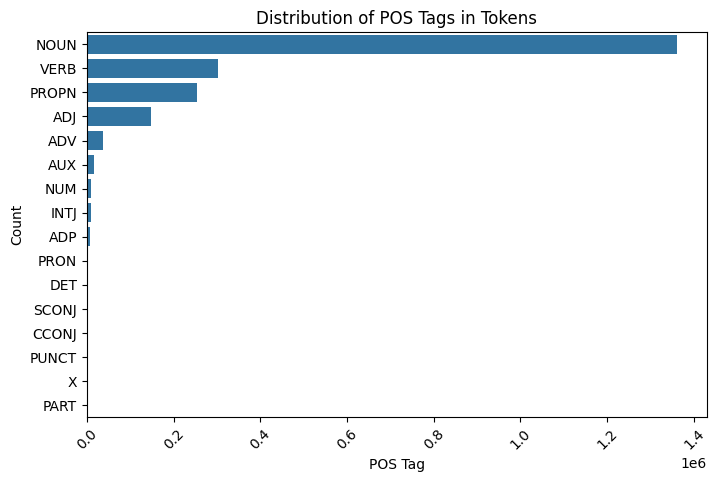

In [54]:
plt.figure(figsize=(8, 5))
sns.countplot(y='pos', data=token_df_f3, order=token_df_f3['pos'].value_counts().index)
plt.title('Distribution of POS Tags in Tokens')
plt.xlabel('POS Tag')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [55]:
def analyze_sentence_structure(token_df):
    """
    Analyzes how information is structured within sentences of police reports.
    This helps us understand patterns in how officers document incidents.
    """
    # Look at what typically appears at the start of sentences
    sentence_starts = token_df[token_df['position'] == 0].groupby(['pos', 'token']).size().reset_index()
    sentence_starts.columns = ['pos', 'token', 'count']
    sentence_starts = sentence_starts.sort_values('count', ascending=False)
    
    print("Common sentence starters by part of speech:")
    for pos in sentence_starts['pos'].unique():
        print(f"\n{pos}:")
        subset = sentence_starts[sentence_starts['pos'] == pos].head(5)
        print(subset.to_string(index=False))

def analyze_named_entities(token_df):
    """
    Examines patterns in named entities across reports.
    This reveals what kinds of specific information officers typically include.
    """
    entity_patterns = token_df[token_df['ent_type'] != 'O'].groupby(['ent_type', 'token']).size().reset_index()
    entity_patterns.columns = ['entity_type', 'token', 'count']
    
    print("\nMost common named entities by type:")
    for ent_type in entity_patterns['entity_type'].unique():
        print(f"\n{ent_type}:")
        subset = entity_patterns[entity_patterns['entity_type'] == ent_type].sort_values('count', ascending=False).head(5)
        print(subset.to_string(index=False))

def analyze_verb_patterns(token_df):
    """
    Studies patterns in how actions are described in reports. shows common police actions and incident descriptions.
    """
    # Look at verb-object pairs
    verb_objects = token_df[token_df['dep'] == 'dobj'].merge(
        token_df[token_df['pos'] == 'VERB'],
        left_on=['doc_id', 'sentence_id'],
        right_on=['doc_id', 'sentence_id'],
        suffixes=('_obj', '_verb')
    )
    
    verb_obj_counts = verb_objects.groupby(['token_verb', 'token_obj']).size().reset_index()
    verb_obj_counts.columns = ['verb', 'object', 'count']
    verb_obj_counts = verb_obj_counts.sort_values('count', ascending=False)
    
    print("\nCommon verb-object pairs in reports:")
    print(verb_obj_counts.head(10).to_string(index=False))

print("Analyzing police report language patterns...")
analyze_sentence_structure(token_df_f3)
analyze_named_entities(token_df_f3)
analyze_verb_patterns(token_df_f3)

Analyzing police report language patterns...
Common sentence starters by part of speech:

NOUN:
 pos   token  count
NOUN contact  43743
NOUN   metro   9731
NOUN victims   7784
NOUN   theft   4086
NOUN   watch   3784

PROPN:
  pos    token  count
PROPN    metro  10147
PROPN  contact   9360
PROPN necesita   3751
PROPN     dave    549
PROPN    theft    354

VERB:
 pos      token  count
VERB      check   3883
VERB      watch   3811
VERB       send   3802
VERB submitting   3545
VERB     hiring   2183

INTJ:
 pos  token  count
INTJ please   1355

SCONJ:
  pos   token  count
SCONJ    upon    192
SCONJ besides      4
SCONJ  except      1
SCONJ   since      1

NUM:
pos token  count
NUM   one    164
NUM   two    154
NUM three     20
NUM  four      6
NUM   six      3

PRON:
 pos      token  count
PRON     anyone    159
PRON    nothing    104
PRON   everyone     52
PRON        agg      3
PRON everything      1

ADJ:
pos          token  count
ADJ       national    142
ADJ          armed    120
ADJ 

In [56]:
def analyze_pos_frequencies(token_df_f3):
    """
    Analyzes the most frequent terms for each part of speech category.
    Takes the token DataFrame with POS tags and returns frequency analysis.
    
    Parameters:
        token_df_f3: DataFrame containing tokens with POS annotations
    
    Returns:
        Dictionary of DataFrames containing frequency analysis for each POS
    """
    # Define the POS categories 
    pos_categories = {
        'NOUN': 'Nouns',
        'VERB': 'Verbs',
        'PROPN': 'Proper Nouns',
        'ADJ': 'Adjectives',
        'ADV': 'Adverbs',
        'AUX': 'Auxiliaries',
        'NUM': 'Numbers',
        'INTJ': 'Interjections'
    }
    
    
    pos_frequencies = {}
    
    # For each POS category, find the most frequent terms
    for pos_tag, description in pos_categories.items():
        
        pos_tokens = token_df_f3[token_df_f3['pos'] == pos_tag]
        
        
        frequencies = pos_tokens['token'].value_counts().head(10)
        
        # Create a DataFrame with frequencies and percentages
        pos_df = pd.DataFrame({
            'term': frequencies.index,
            'count': frequencies.values,
            'percentage': (frequencies.values / len(pos_tokens) * 100).round(2)
        })
        
        pos_frequencies[pos_tag] = pos_df
        
        # Print results
        print(f"\nTop 10 {description}:")
        print("=" * 50)
        print(pos_df.to_string(index=False))
    
    return pos_frequencies

pos_freq_results = analyze_pos_frequencies(token_df_f3)


Top 10 Nouns:
        term  count  percentage
     contact 155818       11.44
         tip 143075       10.51
    stoppers 113860        8.36
     vehicle  79735        5.85
     program  60228        4.42
        tips  57909        4.25
         app  45209        3.32
       hours  38243        2.81
       metro  36565        2.68
annapolisgov  35369        2.60

Top 10 Verbs:
       term  count  percentage
       make  26858        8.90
       live  22931        7.60
       call  21470        7.11
     stolen   8872        2.94
     submit   8145        2.70
      watch   7761        2.57
identifying   4932        1.63
       find   4771        1.58
     hiring   4742        1.57
    offered   4685        1.55

Top 10 Proper Nouns:
           term  count  percentage
          metro  39103       15.40
        contact  33295       13.11
            app  15797        6.22
         hudson  15522        6.11
            joe  15417        6.07
   annapolisgov   5077        2.00
  maryland

In [57]:
def analyze_incident_language(token_df):
    """
    Examines how language varies across different types of incidents.
    """
    # Group by incident_id and look at linguistic features
    incident_features = token_df.groupby('incident_id').agg({
        'pos': lambda x: pd.Series(x).value_counts().to_dict(),  # POS distribution
        'ent_type': lambda x: pd.Series(x).value_counts().to_dict(),  # Entity type distribution
        'dep': lambda x: pd.Series(x).value_counts().to_dict(),  # Dependency pattern distribution
        'token': 'count'  # Report length
    }).reset_index()
    
    # Look for patterns in linguistic features
    print("\nAnalyzing linguistic patterns across incidents:")
    
    # Average report length
    print(f"\nAverage tokens per incident: {incident_features['token'].mean():.2f}")
    
    # Most common POS patterns
    pos_patterns = pd.DataFrame(incident_features['pos'].tolist()).fillna(0)
    print("\nTypical POS distributions:")
    print(pos_patterns.mean().sort_values(ascending=False).head())

# Run the analysis
analyze_incident_language(token_df_f3)


Analyzing linguistic patterns across incidents:

Average tokens per incident: 745.46

Typical POS distributions:
NOUN     472.053033
VERB     104.641248
PROPN     88.021144
ADJ       51.536915
ADV       12.801040
dtype: float64


In [58]:
def analyze_propn_bigrams(token_df):
    """
    Analyzes true bigrams of proper nouns (PROPN) in police reports.
    We need to carefully track position within each document to find
    actual consecutive proper nouns in the text.
    """
    propn_bigrams = []
    
    # Group by document and sort by position to maintain proper sequence
    for doc_id in token_df['doc_id'].unique():
        doc_tokens = token_df[token_df['doc_id'] == doc_id].sort_values('position')
        doc_tokens = doc_tokens.reset_index(drop=True)
        
        # Look for consecutive PROPN tokens using position values
        for i in range(len(doc_tokens)-1):
            current_token = doc_tokens.iloc[i]
            next_token = doc_tokens.iloc[i+1]
            
            if (current_token['pos'] == 'PROPN' and 
                next_token['pos'] == 'PROPN' and 
                next_token['position'] == current_token['position'] + 1):
                
                bigram = (current_token['token'], next_token['token'])
                propn_bigrams.append(bigram)
    
    # Count frequencies
    bigram_counts = pd.Series(propn_bigrams).value_counts()
    
    # Create DataFrame for better display
    bigram_df = pd.DataFrame({
        'first_word': [b[0] for b in bigram_counts.index],
        'second_word': [b[1] for b in bigram_counts.index],
        'count': bigram_counts.values,
    })
    
    print("Most common proper noun bigrams in police reports:")
    print("="*60)
    print(bigram_df.head(20).to_string(index=False))
    
    return bigram_df

propn_bigrams = analyze_propn_bigrams(token_df_f3)

Most common proper noun bigrams in police reports:
first_word second_word  count
       joe      hudson    751
    bernie     bennett    133
    miguel      dennis    112
     patti      norris     80
    friday       730am     36
kristoffer      becker     35
    taylor      avenue     34
      ward       metro     33
   contact         joe     31
   arundel      county     23
    norris    pmnorris     21
       joe      nicole     21
    daythe     stanton     16
  american      legion     16
    online       metro     14
    becker       metro     13
       app       metro     13
       joe  kristoffer     12
      anne     arundel     11
   stanton      center     10


# Library KDE

C:\Users\bengb\AppData\Local\Temp\ipykernel_46988\3514991117.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


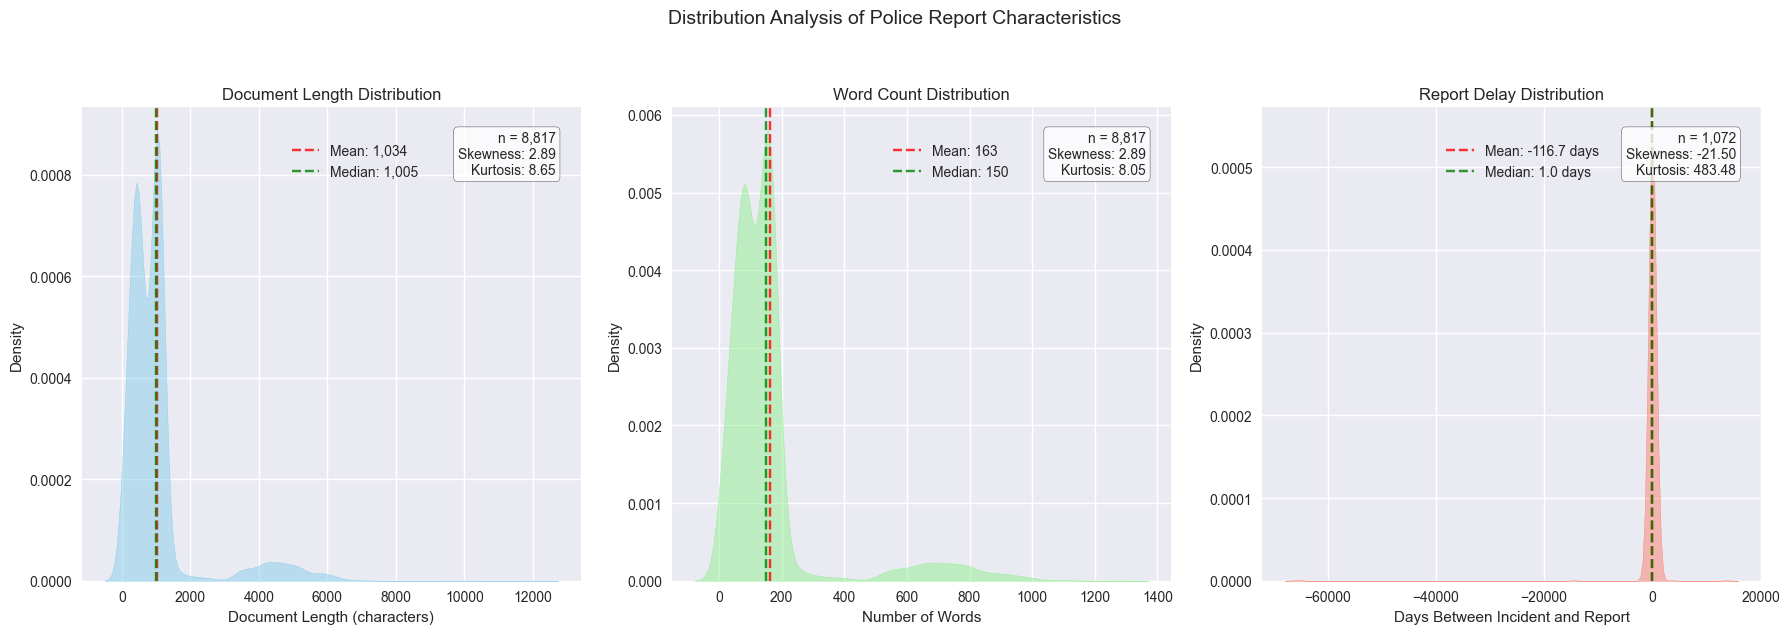

In [59]:
from scipy import stats

def create_library_kde_analysis(library_df):
    plt.style.use('seaborn')
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Distribution Analysis of Police Report Characteristics', fontsize=14, y=1.05)
    
    # Document Length Distribution
    sns.kdeplot(
        data=library_df['doc_length'].dropna(),
        fill=True,
        color='skyblue',
        alpha=0.5,
        ax=ax1,
    )
    mean_length = library_df['doc_length'].mean()
    median_length = library_df['doc_length'].median()
    ax1.axvline(mean_length, color='red', linestyle='--', alpha=0.8, 
                label=f'Mean: {mean_length:,.0f}')
    ax1.axvline(median_length, color='green', linestyle='--', alpha=0.8, 
                label=f'Median: {median_length:,.0f}')
    ax1.set_title('Document Length Distribution')
    ax1.set_xlabel('Document Length (characters)')
    ax1.set_ylabel('Density')
    ax1.legend(loc='upper right', bbox_to_anchor=(.7, .95))
    
    # Word Count Distribution
    sns.kdeplot(
        data=library_df['word_count'].dropna(),
        fill=True,
        color='lightgreen',
        alpha=0.5,
        ax=ax2,
    )
    mean_words = library_df['word_count'].mean()
    median_words = library_df['word_count'].median()
    ax2.axvline(mean_words, color='red', linestyle='--', alpha=0.8, 
                label=f'Mean: {mean_words:,.0f}')
    ax2.axvline(median_words, color='green', linestyle='--', alpha=0.8, 
                label=f'Median: {median_words:,.0f}')
    ax2.set_title('Word Count Distribution')
    ax2.set_xlabel('Number of Words')
    ax2.set_ylabel('Density')
    ax2.legend(loc='upper right', bbox_to_anchor=(.7, .95))
    
    # Report Delay Distribution
    sns.kdeplot(
        data=library_df['report_delay'].dropna(),
        fill=True,
        color='salmon',
        alpha=0.5,
        ax=ax3,
    )
    mean_delay = library_df['report_delay'].mean()
    median_delay = library_df['report_delay'].median()
    ax3.axvline(mean_delay, color='red', linestyle='--', alpha=0.8, 
                label=f'Mean: {mean_delay:,.1f} days')
    ax3.axvline(median_delay, color='green', linestyle='--', alpha=0.8, 
                label=f'Median: {median_delay:,.1f} days')
    ax3.set_title('Report Delay Distribution')
    ax3.set_xlabel('Days Between Incident and Report')
    ax3.set_ylabel('Density')
    ax3.legend(loc='upper right', bbox_to_anchor=(.7, .95))
    
    for ax, metric in zip([ax1, ax2, ax3], ['doc_length', 'word_count', 'report_delay']):
        data = library_df[metric].dropna()
        stats_text = (
            f'n = {len(data):,}\n'
            f'Skewness: {stats.skew(data):.2f}\n'
            f'Kurtosis: {stats.kurtosis(data):.2f}'
        )
        ax.text(0.95, 0.95, stats_text,
                transform=ax.transAxes,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    return fig, (ax1, ax2, ax3)

fig, axes = create_library_kde_analysis(library_df)
plt.show()